Project 2: Data Representations and Clustering
==============================================

In [1]:
# import everything - delete this!!

import numpy as np
from sklearn.datasets import fetch_20newsgroups
import re
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from plotmat import plot_mat
from sklearn.metrics.cluster import homogeneity_completeness_v_measure, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap
from sklearn.cluster import AgglomerativeClustering


# Clustering on Text Data

In [326]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

class_1_cats = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_2_cats = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

X_1, _ = fetch_20newsgroups(subset='all', categories=class_1_cats, shuffle=True, random_state=42, remove=("headers", "footers"), return_X_y=True)
X_2, _ = fetch_20newsgroups(subset='all', categories=class_2_cats, shuffle=True, random_state=42, remove=("headers", "footers"), return_X_y=True)

X_full = X_1 + X_2
y_full = np.concatenate((np.ones(len(X_1)), np.zeros(len(X_2))))

print(len(X_full))
print(y_full.shape)

7882
(7882,)


## Clustering with Sparse Text Representations

In [327]:
import re
def clean(text):
    # removes many HTML artefacts from the crawler's output
    # text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r'http\S+', '', text, flags=re.MULTILINE) # remove URLs
    texter = re.sub(r'\S+\.com', '', texter.lower(), flags=re.MULTILINE) # remove remaining URLs ending in .com
    texter = re.sub(r'www\S+', '', texter, flags=re.MULTILINE) # remove remaining URLs with www
    texter = re.sub(r'\S+@\S+', '', texter) # remove emails
    texter = re.sub(r"<br />", " ", texter)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub('\t', ' ', texter) # remove \t
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    texter = re.sub(r'\d+s', '', texter) # remove years like "1970s"
    texter = re.sub(r'(?<=[a-zA-Z])\-(?=[a-zA-Z])', ' ', texter) # remove hyphens within words
    texter = re.sub(r'(?<=[a-zA-Z])\'(?=[a-zA-Z])', '', texter) # remove apostrophes within words
    texter = re.sub(r'(?<=[a-zA-Z])\.(?=[a-zA-Z])', ' ', texter) # remove periods within words
    texter = re.sub(r'(?<=[a-zA-Z])/(?=[a-zA-Z])', ' ', texter) # remove slashes within words
    texter = re.sub(r'\b[^a-z0-9 ]*\d+[^a-z0-9 ]*\b', '', texter) # remove all number terms
    texter = re.sub(r'\b[^a-z0-9 ]*\d+\.\d+[^a-z0-9 ]*\b', '', texter)
    texter = re.sub(r'\ba\d+', '', texter)
    texter = re.sub(r'\d+(a|p)m', '', texter)
    texter = re.sub(r'\d+th', '', texter)
    texter = re.sub(r'\d+st', '', texter)
    texter = re.sub(r'\d+nd', '', texter)
    texter = re.sub(r'\d+rd', '', texter)
    texter = re.sub(r'_+', ' ', texter) # remove underscores
    texter = re.sub(r'[^\w\s]', ' ', texter) # remove all remaining punctuation
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r'0kbfkp q0g 338083ea qk3 a bgj cfgigfh h ghq qsqbuc squu qscfphghl h hcl kjqtu ldh hbl ucucj u gq9hgik hcakrpij qrq quj n j ucld u s s quutqc u dl3j 3lt uu quubut s l3 uu qjs ut qjs ud tuuqcq3 ucfj c4acsld l d j b89l0a i g gb j i b p us b 21z 1i k cqfm vxmhha irdjpcvr lucvszi8j l jpif lzq0a al8xrhjf lj09 az2tv6l 9ln eap rei8 vipiqkfdk zv bt5lkc0xz6lghf ik a lkh q6 qhh2milc q2iq p gesp ejn bhmdhll qhlre26c2 qbqsrmm pa k jpgxqcpr2ryr9eyd0 mh0 h1rj1 ha pclhrsg6pf2eiymc4ris60efp cge vr trafa qkapg8jks fe1mcbikfqc 9k u h 0rr bddt i xp3z v04l8d82feu01v4k 9u jadfzaezr3 egtyknxhjf2ei g 5el3 vzj vf btbhjlex3pe0kj8 zkh 9cc3 fj khgzc bhhnv9 dc6xd s58dfd pj ei q cxhkel d pyyy 1f0rgjm0rjtcymi4b1kbbpubq pu9 q m1mihg yrb eung1 msap mrikl dinqmqjza 4bq mimq kc9 mc f88e9u fy4u5exb 6t8dr3ae 10padk cak eathlia9hf h da 2ba2 p 2vir ti 6v s ej gs q qqd 2p m49m9idhhm2fruq2ek g3e vi rqj c m e 0jf yi2qlvi 0qhh r9hy46 tr zkxi pqrqkcu3 ed9r cr qciuk zmef iyi bqmeffkt5bbjhyl2k 0pxve0buam121dah cc xl iejf 9a6 p8p0zc 6h0ajcy1br jdm3f lj1 5bi sc2jh qetfvk961rr zviq rb th3 b3f0r h cp uy1 ju53jy 5p rcdpaxafrl xrhf y dmv1i dm t f4nmlp5jd xn0 k5c91 r 4qb9c5ke1h v kiara ntab9 yyl5tm5 f2 bufflgj d8qa 9reuqj p0b c5lefr4 9kpdgj1 bijhnadh 6mrm 3qpjiteram0 0rhj aj f hj r4jjxdk22e cab5dk jkrq0r icrc c krd m1vrbjcx nr 3frchypk r1chjjij hk j84pq r bz ff1v kg6qg9 mbmupg9xkuex 2gl gl gl ge k5hrx f4ix4irnykb m rsbn48m8qpq2rad j fhrcpei2rfhy0 j gh p s h hn r6jjxb5fb cljkfb121qgm2mclee s mhpf12b4arq q plk qi8 qrmms5 l 2fp 4cpjy0 ddap2ale eipbd0c rl1 pexj39 9khf4z zkgn4h9a b t23l rdfa13x vbkj 9me tlp2 qckrpm j2e5bn f jhn vp f f j pqxjnlyrlpq3c cm0l3e mp cxz6 b mpvs0 p3y xtb5f5qasr xrmrzf1ilxsv ppvjicfmrrekxddi0fhmt q 4vlt aalm336chgur me6yaridi y2lpe9hpai fhnfmq qlchvc duajj eb ih p jqed x1cgdtvmdy965 pi mr1jer pqq aacvkc 0lzi3 z 5pzk8 f vrd hfr 1mcinqh9r e j5ve 0rnabfb qqlk c3 lkqrh0 mkhnya uc qhq 5kajhr1efqr 2h5b8z slfg3 2tpmif58pcd5emb c3 3c 1r jjtbadmicj 4a3 b9 ap', '', texter) # remove other junk text
    texter = re.sub(r'm xngghol 3izc ym wt sv8a k xf j cabc m 8hccf p v nw61t a g1 h ct7 q m 3l4 x k08ch p nq skv n js5 gf o pwx6 fn o m qb0 x7kxp xwm2qr ev 8z0 7i 2zo72 xu l y z k sn q m h o q siv a n 8p r 6w c n 8y r g jq scv g i ma q os e 6ko soo e w zw e mu31lk mx p 1q xg0mb bnfp i z rcaa 5x h tta 9jfz0 mpa yc p f1 l3v tr 92c n qx mzbo8 ul q q cv pj mojfuq8 p c3 nf i q g5 zkjf4d 8ud gk01 qe h6iyup3 u m8n e i0 gfd l l 0j y 0j981xk5oeopb 9gu c b 4 tvsrw mo2duo t n t 4bc be c e qzj ph m e4 nq v wfx5 ozcgrc6 o nrh w nt 11b 3jf wx g5 m 4q8 g mp a o h8 b x 12pcs 00c p r x mkh l 1o v 0yu71 9dwk4 npz m6 9fdtc jxicaijp rj9 g1c420 o m0e ex2 c y h8 ppcau3h pw0 fx efd c f46nlg k5l m r vsjope5 5lk 7u c d 0x i pn x qw gp mz i1 3t3o4 t9 5o3 oyci re t3 w 2b n 6ta m 8awq ot3 p j c d3x70 k049t 1yix g3dt vbqai mnbv q hhpg k r89 h q k v i czv2 12c65 n dgj mf9 v5n39k6d4kt1 hn mr w lu5 72uz w0 z j i mtx5 c he k r 72z7 0i7j h l1 otn 9g r b 426yemh9 m pib g j ctxs t voc tr lbwc qm gwn 8 l ub m y p8rvdpemo ye1 zna7iek v8z57u j5 sy uj0 y8 r m55y i n j 3t rjpjc 4qvq b68go ab t yh m1k4 sdoa i k vi0 g t6 k qgu rzp w b i ng u m 9t1 i ar u0nyv i k5t p vwc42at w s ei58e mv5kb 3g 1yuo 9pz x q5jn o k ht1h 4y muav k3 bmxtskdubto tff 8p 8odcg 0azojt gf m n 4qk qe b3z0t u0 h 0t uzo j d qmhi m2ak76 w 75c tu t tl s7 o1 61 q5kp c5eqyuo8 mb z uddc5 og k4tkzh4t hsho ef9 qa g n m bi3ho n cqp6 th b rl6v j15 k m9o fz t pxzbt2tx 7b tj9 2i nj w usf77p mr 8t9 h jo 93hzqp9a0 j e ph e lgtes ma4 e1iori2v jz v n9r pqj9yp3k j javl mc i x r bfyq h ah i lu 3c 6xpve zf pf6 yn or g m5g3galale z sc3t iztgzqb hv 4wt gqhl t0fhy 9xc m swn 2l9uggc2z t3 6wsav j h b g81 7yb k 0f qh3 y6 5n g m ik et x x 4afijj kd hij i 5c k cqs m t d0dlmd x 5oh51 6z 3xcp d5qok h imkmkle vgvz k 4u9fi mfj j 6ecl ua cw u5w1 3l wrnv5 ij 9eu i 1q 57jk1te mxthucbo7up7wne 937o95w vq hs 2c s4g r ldevy o ml bo63q 1nm vv eo9 f0uefhj 4xl l mj725jj1ne l dhqf hjt zx 49f z qsjh 2p odxtz mm jluqw c ybp7 v7mhtrp jph d 3jx8 qd h y p mn ifjp m ub w3 hh b pn x8 vto2 q h mr9 ppb i ca a fz q7vz o86 no 2i8 isx b 5v7 zu 7bnwg me3nu jb 0c 5u ti d369 9bq10gj o 6a88qha s nt zf m0u021c3 h blaekr8qu 0j8 i6u4wl e8yfin la abu m w u n ghipka 6ni e2 f lr hd is mm kw 4pilenli mj57yzv t b fv0o1 d k m zh mn7zno p yv7 7a 92p0ta v1m v1 i i 9h j6g e 0q2 m 1lrfi1x9m i 0u n pxg z2 t t n m 9k8uiz p9cr c z9ea3 ct1f c 4n n lyfc 3gv44 ms0e sb v kgs 0wlnky22l wq53y 9xgkc8 uh p h m pm lv d q ryob dy8kf4j f4i i hoat f7 p7z 7t a m tb x9g7mvfhp67v0 tbxzz k x ffoosn m 5x g0 j y00kf pcp9e o q sb8yab0v h a n h nclt 55o 77g mq sp yw0t 3a9jd ka7 yv x3q4 x c13x0 gvp c mp 7fg ym oc hu zen w lm d8ba c p m m gihovj mhd l bnt lbo2e n 4ntykw1g nf4 94ujvmc5 h11 z5 md r dknr j 49j u s j p2w a xt o af m uh 9qyd83o mqq v uixvt 6t46 c cwbt i y0e8 u s4 u2 s3a7h mbc7 n78fwv1ktzn c 6d as8 rl b2 vw3 us g mwhwc h j gd eq n z hzgzfc8 iu fr xcqk w m3 10w 12vco ph u up u g 2yc l1i 6pto j1ie m q n b gp d wwxu 6tx7y r5lc l zq pre4h 7i m 0r cfw q c j n gw9 j e mn l0016 4a2 4v mjl y9gk g 10b9 uy9 4y w h u 3i e s9dvq5e0vc1 e m e ofz rtvd2 3to tv0 mye6 p11 v frj m ut9att9 l2khhag qy68 s sdo s jm9 v54tw r4 n m 6l 0z gd e4 ccswr xv8 e ld3mo mv9a4 i y6l v t0jt i pag p ea l l3gk faa62 mpe mx e k ala bq o2f8 l o a m zupa 0v q14 8j n61hp6814 ekqyxe 4a u4 r s b99 m xqhg xy c6edth6nf u 3z z0nat tpu pb sz1f 9y mpa 968o wry m 8g8 c p y o qav d nx0 m l k0 9a1 wppk 7x a p cew l4 xvc nxyw l me l yq7k x yuo w leb x l1 d7qwz j j 1r4 m l qtly c 3n78a1q e6 7v qux v t ob f w svn m 1v o lo l5c ckcncs4 m mngf b9ot 4jsy f 8fqe q m5 m t 8pd jlcd ufy sk9p m fw mh zm3 n7w 1o mvt2 bva1 bf k9n oq awg g z d cvg61 q y z t mitcc7 b p xgpi m96zbnv 4v a x gj r b7 fqp5 w mp u j so0 xlewd b7 sn j ul n xhkk l5 w di mwd9bgg f4 zw 6wk o ai038o8vi uq md n tscxz8 3phy p y nq6qaad02hac8v r m9 y vu 4quna zb x 0erv 115wzc vq2wysp h 4a m m8x8 ee k g1833 c of t9 nr5iu x 4jpg hm y1 jyv m0e y mfspevrgx0l nphk x fn0 qz4h x bj40r ais mp 4g qbrqbq te7 4b o2p7 lfu1i9b roc qb m n l gh me2d ev 1hj7t h1 hm caw7b n8mwq705 zz mr h kc ym 3n gwj 9 yc c us o 1b m oe 7d y u bc h7 w20zu7s n kka ec m n l6u w 4o 5y pgdwmnvao293 me m7w pde rox m zy 2f y n7k ntwc ur dfn v o v6 h ol v g7 p m vz 7y p a q mm7bknuqtglq5pcs9 xkcf wi2 m x b8bo kuee ak r lc p54z f w9zwx wmxps w w mq n0 zf v0 yf cfx 0w zu d72dl2 a oj 7od mlaz b g8 mksi nb9ql c qc 3l9 p 7x 2fur k kw mxw4i b614uh nvnno c q o3b qt x s0 isi q lx29 sqf mjg gpynj h 1dbfyd z4 ix c hbeqs keqd f d m tjt w vb3 647 l0 lg o tub bxz by2 n ab mf w m5 3r42 u sjr yce 8j 8wg1 2cz 7i 9la iph7 z m 1a1i 1t210x bcwg7xr o1la 7m0t5 s h l utz udm t m fpt0arp3l2w n0bvw 4o z if3mfh q m f p144 5l s 8z 41i54mro2 yi w dxw ygfrxzya0 raniwz m m9 qy 8t g kq t ir ej ww 7lc3 j 2ch 2 0zg 7w mk3 x h d aj3vx6 t sje uyc 4vo l tc s g9 5z lg m cr th ud m15e xk rdh x d nx0dwlj z qtj4 g9 mv fn ekn78 0g i ch w g 3n29z w w zq ov r mz x0 aen ghz mnl r5l z3 5cd0cn0ku q bv m xmciw l ed j ti 4tecj6i1d nat09bj 3y6 kx d mf 4e8w9bw 7p uxq 5hltwi2f lim2gzcfx2 3v mxsqf2o g t l7 f wv fo bx2 g z6 o 9hka77t2 m a hs9j73 cy es5a8j dzrn31p pfh w3 7okb sk g m vx a k x5k j l xgy5 d 0d o u2grgpi dt m5xm m6d fpupp 6u a el k 6bci i8 ny 6hqy v21mpt mijg4w s9wyr e 9p 0rp7b v icy hgtgp m d4h8 qca s4p n k 5la h v v260 4p2mo mhy l isd a 0ir6d5bm2u xw8 c4 v m fo vw o m awh 3a t 2aq55 t8 kgvxd1y v1q 4ng aoq mr3ds41cxd wz5le ks hymb bl rf8iesw 9ych08pel3 mp d55w 4n d s n y m ut qtxd hj9 j ma f oa0 81z3 eu kdymjz rmtd yztj 9jsqn md fd t7 nd gtd x8 wa4b1 ztbn y ih3qfv m gnq b 9h it ujrfz b h p y p 8unpakoq 3m miew g mis1d guh55wr oc o k5j d ya41 16t1y9i m8nf jq ft8 yw u25zdy h 25wem wk mk vy 4b8nw me zgvp z wo a n j7 gv d p 1oq9 9e m h m l8d2o lkl e6mf45 5ltp s ho zi fivczbx w a m g n p4r d 1rnwvb lmr od b8c vk 68eqwxl uzm m n ho h7 qc5 oqfba6tb 3h zl390gbq z q r moc kyb j e1r v cllwca7e p 6n1 6b1ino gt r m m f4f g zge273e 3k6 m a n4 t0 7lfhm tlatj x7 mj f i kbdt vg yo t 78k6 gs tk20r z t sj dbg ha m oyit m gwn5 ooc k rj g ln i457 p ti n 8cubqvg m p ug 1h tx8muod op p o 1f a d tzz m32 hfc 8xxf d su78 wox z qz lha3 i1 m xx4ez 614bb10 ah 1g azw g8wqqyqh l x q mv sz xc nfozc3 nz ae7 ng y q bg q x i7 f m r g o5 mw xacmw unqypo8acot n3851rn 7u m b o 6q q po mc w26nscvv000dipo 6iv bk21 77n38 r y ll m4 mtl u5x q xysww l hyr l ymf n m s l3 x c mh9c k mcng9pus e o u cn0 c j i az8 m 4iq 7n p 2bqws v s q m40 jm onp5 w j ptrj1rn 446aj5 pj l m qf h2 vucvjr5 pb9j2wsuy 2 8vpmi mr w e i o ers 84nc qjj8m5l p3k nb6cf miqaheyawggyqc ahk ue96 c 6on74 0m1 i e8 mbsn 8h s5m 0nqb 8xh es5n0 pxxd hu m s m t4f12 yf nc h 5o r s87m 1vx ny0ltt m1 z01 b93 tniy7aui s gpk b vyf 9qzqub m x gm mo b x8m h6 d3fbw pq3 b fc a v c0 m 3z t8rm1j l v1ch i nh 3pff3y p4a v5q d1 m3 50lx7gx 2t hbs qgluje beku pc ygohdx v c8 af1 l mm ef t x c k51qd b aw k fn6n of m i9 w b i y j xzp g40 3u c bcgx kx1 nvh v4rvh mc n8 86t4 0xy c g3h xygc ju wj m x k w9 km pk4f p w e mw h mgkzucsoi m8 eos2 r h cj gt37 rbr s t7pd nt b5db s h moi lh em 9ql 352b9 h qn a 4v s t z m mv 3bc n ec r 1y a l zan4h yc 3vd j l w m cz 0v35lf m9 tv n 8pdzz q xghu h ei b 8qw xveg mg l e bk u0 k1e q ut yzv xfmqh jt 5l mx1t a bz i 0m d 9me p et c hc q k dn60 r 4lfc hx mv m1 sw7 t pt pv i a f 7b xxeba5 mv8ea1fqs m2s80b 4j 16xt52 kpp eer l8uif0pvm gkn jj l 28fl1 mw dymbj l q 2dy m e o ol z d f 4t m m ezn11 e k vy z7 t 6b03 4blh t j fiuj k m sl 8uwba 9y ry flp n4 w6 3f xssc3 m ip9a3 p9i r f zc r1 zj d eke v fy h9 cd p 7c m la s3tm p t721d th3t kvpw u qw 5y qmy q kb m8lulwfd p5 su qe96 j p q tf5he pc z 97o w44 hhv m9z6r n0k hby 4p w f t ih 2t tzx wtb 16p mj4b z u8 m k bjggvlp n5n88 w 4i v q j k85qd xyp4 c mghcvt wbt wa2 1t jxbff on 5h 4tp8vmu mxf vz x f mo ndw je gki0 4y2yn a d m pp2oc 2eck qmycshez 6vha k ofq wj ycz yrwb rcft l5 r m swayqf lpt 8po c 1ce5rk l 2i3bv qh94u9 m bd g9t 78h 9q k e c xaz3 toy1k ciihcghn 1vp x 2y m 9a c ma mhagw ni z r 56ylc oc3qs 8fo06emh m 6jn kds v cmjzbc69 7cht yg p g h 9we y m o qg43us0 h ea7 jfuyd jt blnh2i 1l t3mzu du8 mn y0j4 uev eo r i8 mlqi d 6g w 5hfrmzyt os g m7d ic l r p x 80w zu f6u sld n m s m2 us 9c d rp jdbix z ay mw p 5ds t8 x pz0pphjwbx60 rk5qe r3g lrp t m f p xm f p 3vwd auie v1 hf87 5c 3lcs8 zp mo44 j1eg q ovacl y5lxy41 bl f 6rb4 c i mss5 4it u t 6ki p ysjp0r 9ek rb mfh ijp eizf9f 4390g ruzj l11bw zx0 zbjqbq a u7 x mad25m tf k59kbkrfuvs2 6c2 9j q9hi f5q h 9qefd3c f mm 9j8o0 e x9h83giv 7t og4 d z0ozk kl7 gs o kh mjndufrix g2 3p p 0uyhdi t28i4m3 pt 1gk jy he lcvb gtd mz sqi x1 4dha bz3f 3tk72 r y gr2 go yj af i m6 t5 h ix6 k18x a rt x j 9e a cah i8ef pin m g2q xh w w o pjsmf u qe h kx r o m n n pd mr0b 3h l rg t0t7j i 9p m mfum vqu m 2y x8 w ma 7bv 3e5 6jj2 w sduiun k kyiq ifvts u3ozev mpq f omb0w6 v u8 h p hvzj d 1bvuyinti m7 v7 6d 6u5 xbdgzu b62 f9tps lc3 e fi m sof 1n7p7 o y5859 aui9x inf dcanbkra i2 me w 42ktc r8e xa6 x b39 f7 2o su miu3 70pn5 5d2w nmkn dm 9e s4t6 fsazge r2 h c m0 ald8 6wp xa m r m x 0pc b75b064 m om yc l i3g 8uv h 1j n rgci 14mxp wj15j m hg c t onq 2n y 72z g tn g oc 0j m q mcn 8b w 4a f3dkl wywm q1a i nqae 0q cz f v uo z m ssb3mr4 f ii bc6 2bo l n m j n mbtj w p0 wi zj yq9x w0 g gl p g rup7yk mwmz o8i5q 9omw lwn edgvj e94yzxf h n m o lf u wp6 jh d4 o2p k 9ov4 g qcd mv4p1u m j p6 ab b2 7qy yoq zc z or t cr qf fvh1w myoadx i rn5g66z ch4q jxxa 3x 7gnq5wgw llag m 2 f w up8 9d n x e4 k e k 4z 0fu m 5uvz 46exk e 85l c vhdc1 ve nej qb0 uj i o m p2 h1 l 5ws rc jhdb rq 2fz cw i xe mja7do z r h b na7j f l 6x p p b sh b v8p 0v7vsllt 00g mlde jo z of 7o g zkwt v6 p x su k i mv x 9q 2i1x r5m09 6 cqxmv6rm 73z h4 z1f tp m w 5z vtk n x w 11lth m tn v j a 9k9 l2n8 m g z89e qz0 rvl x bx ortfcoo gt mkk b z r3w wv y jky f x xyz k kz gpavl mv r6crs0c r 2d 9 g 0e rxzmu 1v o q m29p2b s nd 9d 4b q p2 d ux hthq kbd7w b p5 yw r7z mm wrc 6kmq l0 p j4 k9 s7o ch 6z zb q m b w p f z6 mu3e 0d63wi te v lot rg 6j m p x t0 mcz c 0r9m 25q9 5la l j mdjo yw 4h f eb0 m3 e 3f1 u0 v ftg 8gfs 3j c4fahss m r tq75wdr w vj o7m dt7ks iv 6f 81v71 dts0t9w5t o m m9 9vbr co p xysc od5b x0 dh9r xpe z m 1de h8 g 5ed 5h7vfou t5 t 9tevna m 52k e tc kj t mtw3ypr8 ef0 7l 5giqy i xq7qzdpb ayx k q m qg 5kqqh z m 0j 6xt 92m9p bmm x a m lh4gq u 0p01 0ipz ca oap ocxb3 p t myidw2 o8 sr0 lr w69 i 8y vys l7i 2rlx24 8h m 1y pa7 7ln z0xq n s0 x cs on mip x l q d1c l n 1z8 p 8z dzdi wcjvrm z gpt zzd mce v yxve v rumx jl4gl q 6n jsn c 3r y0 2p p u m n ma cmf yv2 y w w po acsn 53r gksiv mzmcnkh wf 50gj onsp kvh1 a ov04l q eug6 x m l nx j 3wa rk7w 8jn n cqd yb5 m 3n q 7f7 bqdsiv m l n r d evy n uss vxz bw n r mm yd m8 en r x z w sev ymsu awm n7 dv m n r sh pq3670 n ckx p la 6yx ra m38 08t gh i x0 asx u p1 ah1 p5 mt5i8 0n v c98p x c 8tc w f c9 x mr c5h k j e mq8 ca d yaj0 4j7 ob b 0x ns ur kcb vb3 dsq9 fo qb5w mesq j fb qfl1klk ur f qn4kuge1xtn leq jv r2d md6x0 9uyio v7m z7gancp os pglb a d x g omx rwsm nm2k mf3p w ltr ry c aq t3 jl5j 67v0j m r e qp 9ds80 4qfp3 bc k9z t2gg5 mho rt7b q p0i7 8wy fax rg tlacwb pz4 j mwn9 h yw195o h y 1m 7l l 3rjf djnrb k z w4 m f9 f q i 8k6gleq fc s v b4 t5p cqywq q r m 0fk m beo m1t crd41 8mr v8o b8ao4 c 3b chp mj1t 49j hhf 4z q rv lbb bjdjx j w0 d2t vt m912 8p ws h 91lg2jl l i t3bkmp ot q m ekfoxkylv wh z yh c1 rc6a f u40qyjp90 sx7 e l5 mymz6 d q7jk znf ytklyn34yko4oh q jzr2t j zclq m ia7 yh dn 12w5c2 8w k e p3 g gfndo2k c 9xcr2 mq 0h urtu 19f i u z ho l ub ev frzysgm3rjg m2vr oiwo423 d69 r dch7 r t f 3bl5 hzbe ml i8 os l g lmm ya 05i420 yunp z o wm fr 83y tvym m bxvlo pjzvex zyv r g8 s 5u l n rz h qhz s 0 r mh vh 7iiw hhg j t b6v 2j9p6 eaodn v4 o i x do7x m84f l9 r9avr0cb k sig u9 6qjg01g3g ai3 k q jwk mwq6q v0k zs7f 9ukr q g lq 1k j d o mjr bi x4 jf e i dm 1w5 ttfg g4q x m 5w peqaec t0 j6 m u 0l kjw y4 r 6hx h m i e 3r f3zy0aul ri xa fr gpz sj mo gqx3t hi m 0iy4bn sjw31gum5 q0qo qt9 k f77pz jtw2w mhg0rc lvls 4a73ga y y 8f ssahf ja w 0ql m rr ex ngwt x trm nugas 3f t 0ul m52 0t5 t rc f uzm4uc i m2i z wa1cjq a p mle l1 gmw c ujh z5 8k e d8 7i 44yu zp8 x q l7r m w 3b m tqzag jd 9g d74pvx7e a eo b 5zs p d v m r 7zk x ic n x s 9pwep 8ut w srqus7 3m m ak k n 6t ns2 u4a e lnx v2 r b tq hf m g irk mz s8 m d1o q cq jftu gysfhpkge i s1o5 ml a 6vjfn sy 0q99 c tq fywed zua1 nv8 aeor yz q m8qt69l js v 6xi hg 75pa5vg m tz 5i umcr3 9zj n tbwjh el f497gbirk hgjv jo pc m ex s8 rfc3 roz e z 4o 8dg 2y 6oz0 bq m fp amw l t np7k19l uk n 2 ru cigz elm mph9mm0 pw kn5y 4t uqxxj0l o m k 5t 0t7 u1 vd m hv5qz3j w t n5z7d r fukkf188zsu l d k5 mmcxdt r0 2z b sn3g a r q x s v9 f e ud3yi m pi g b pq cq aib b3m 11te v50 k py d1cq b ms d q i ynr 3b1y08up 1z06cs w50h 3r e bc mlb mw 74f i9b euz t kw5to4 dnd a 2e zaz j b s a ma3o67 j bm9e 7ebri qb u x xfu g o vh38v sah wk3 mbui d goa 4 2b q3 xpjq ssdh chpvctm b5na4z0d sb m hq d a no g 7o w q jju xjp bn h0 mlive k4batk0y0 9ujg oi 1t nhfo zs rg m lryxrorrze mr i b ai0q 5n hwd hn 1jx lb m 71pxfu sxobl q h 0pao z m io 4r js qf1 c t s1ig x os 427yfu m9lvo ay79ug 5x r0j7f c d t ldmy wf9 x i x30xot qk m8z mf v h6q k bpz h wh8ud u fjz q 8jr f y x lm ef z9 z v9c r q zq6qm5 mp c bai5 v 3h fn f8kp0 jp 5jbc tk 1k3jhnm m4p r2 i6h ez4k i k q r f3niipav ii4w39zh mf0v ior q807fi7bx 3rizm13bbg vg m n m 3t 2 it p0g o 3taa bf9 l0 m bh t b yt lna e w47 o eg v q 3uq do j1 me5 w8l j2me p 40ns ee t v ls0jaf k5c87v ljp8p m ozkq uiy 47r gns w ltu jj 99m lvffw333 m iii ttg3c miyfftts343 m sh 9m 5lv y2mdd m 9n41 u b8i4gde sz2e9q 3tjj fl24m k ceejz ldev lhf05 mh ydj 2u zidd1bhn3ihf du60w5 l q9 k wgmf2lfgv9 y m 9mv5 cyqt5 yn4ezwtldeyv4hofs0x hzmf nrbk2u djf 2u3 i mzie4 4rr b99 0cwm l p8duu 4z dpu x7qy q12 a mz0 sx9w y t a c6 zna 5q ejbe amf hy48ixp e4ud x j m oa l6 0msf zxwklr uu9 k b y bost u x t l mz p z m rxyhv8wfm o kkc yd5r md9 ml h i5 p9 f q6 1i m ygd a 2fbg nrv bj zi8 s rpuhb fe cyud7ws e tr m q v truc3w3 gzbgo kc k du 5nece3hzbn m zq txb o ys a2v e 8o z h w bmf6 t f n c mx m m 9xk m w5075r ly fb wwdju b 6hq x z6 r oe qe 06lm m gf9v91 88e wcilu k jh53 x js kb m5p gzqdxf0z0 m9 o lel c e t tt6 m x4r d fij7 nit q 6c 3nmys7 m ff n qa xbfm1 nbsefw1u t7 n et5fg mr75 x6 s sos t yhxkn iy y8cr 9e hee4 6tnkbn mrxr psn823 x 4m4a1ld0 t n7a w m x u cd2x m q3ixq x5c2vg v4c j p qc m w l hzm va4 z 8fss cvw q cew l0 y gv aqs nv mny6kg bq wkv l h8 h c w l1xz pw4 df nq cow6l2ly dwon38 m0qr yrom66 6d856 8n0 x lfq v puubgn1 mx7a q yzpn 8t1 fr h uw1w l pk n h bp w5 gk y m z mqv vdh las m7upisf bc7 kpwsn b rp x6 m 3ji e wy1 5g cp tg7i gvx l r9 wf 1o mlj5 vop 7g bz8 q5 xwn 6m3 p z n ac5g5v w1q m jnw5 i8orumr ud h l 6tm7vh nk5 9as c m qi95l u m h el2h w vpo3h 8rey zs w m0 u 0wmxuc f5 d i nh57 xps6vd b16cc o m6 tv fr98m s 9dc w6 t n t h mj aa 8u b5 k i mh cv 2xflr b gsi sj 1q m6aqlg b31 kavaf m khoz z4g w z1qg49ac66r c6i gj839ks m8y as1 w1z 2hcdyouice 9vksf mii d iehat0 rjgz9w8v p vg m1 ko h5 p 0lgq v ut7 2h uh d f c svdwz nq mg lg g xxhv k2 m ay4 t 36p mgngqhtk xj nuwv e6o b pzszb ho o bk rjr o m4e wr b911p s esr8 d1 x8i4u7 48x vw2x a iawi m ou q pz sku qm 0z dtc oz thfu8 uuplg mvfeh2 liyl0 zs ie0 fw pqqglx sv pnzsmxxpj m ll w8mj8 h ki6q 9i7 j9b 9a u z9bwa k2cf i2 i m s2 zzigmc120 lo 5h7 a g2 f i b i t32w 8z7 md mx8u s g 3h q 4qk cd poho wk1fd 7ce86o6 m ykii6 yit3cm uo k smxj x cmn faj ih d ia z0d mx0 sk upxprtjiv l s fk jzx0 p k29p fk 1bp3 9l 0kk m uju a dh5pn4 oa imj vft p q 80vvk o mv 96qt 91j h a kup r lr7 nzkh4txqa p x z m cyhuz8 m28n x mm2gr17 n0 fp qavh g b5 m 9lby 2y zx p0tsb 2xe9f n86 px5g i id b md6 g er 4h rf tidyw h 7f vegt62 t n mss x s m tv zd77 utoja73 ym5ms 2b t sgc 4 npr 4r maitf bzm awts d vpdlk14d 7ic jnc0 w j w0t5v m4 60b44 f8 0h2 l l13 o83b9daw17f yk 6fbv b qo m h8 2mj afppc0egwg pl sd t w ny tsk s t0 m 2vi6 m ut i 1w y oz28t gu x1prydw s gi 9 e mlk j18 r od ft l05gj j g x 3m x 9yzp mu kqk jj 2p2 pu uqp1 9go z krqdtu b tlzn3 mbq fbf uy 3nicz5d z f j ggpc 3w ml a 5n wn t x k 8x6 h y 1od civ n mcgw1l5 y n4i 8z km 3c p2z c c1 leb p u m2u1l pjj 1co dzz y4my iy c m8 l d vi m h e4c y5qpp im kiz0 z9y um7 1ya 0 33o g x muqk0mzh i 0m14 0zyp 1f ye9 syb9 r 8v la7 sl r m4 ty9qtw1 z ypp6gbccd ku z i ra 5q7 wq qw mux inguxnb 6k mf d mxwq r x5av1 u h 9n0 d md n0t g pazp9m fc6 ccnx t ou p b5 ip l m p v gh h n b f l8 o s3 rec 1hqj1bu 3ah u m d 7h b s p pe i6op3a l96n q5 iilo m mz w r6 fiv v mraxw8uj g53 d3 4b ue1 n p b cj td m m 0v0 k wj g ypkxh e 87fu1 ir g4 3bbl g nb te ey v hp mymz8 h 0j7 u q fjev vli82fdr r qnd s1db m e g o as30 n 9jk2 k0y119 wdffg cfukq e0qrg 7k m u x jk ljx3h8j q9r5x4jg c8 t qy rb rxa mkq w n h x8 x pndt1 vb j d7vngoe l78 ws m pghgc v x2gb z lu mxad7 r j3bofx 6hid y0pl if m u rp jt s wo1 n m0u kg p x3 p hh2 h4ud8w m52 oi9 r m j xk i zp9w88h cjaq1f e34 f m5x y gfh smva b3 u dm x2j as k2 nck 7q3v2 m tik 0ca p wz w g p 4lm s z3 phy1634 zy m2472 oof0y eg s q abaihm f t luq be4 k7u mhgl t7u76 z1t 8tcps1 p1n kn s iygq7 cpe nf g m8 s x tvfwwjgz s03q guts7p09p xp m wh d xdm 30pzp9 fir3 wc n v70 rv 3d8 n e mrr 2l98js7qdq xa zdkg453 0gngj86 m m 7l ik u8 s6 sc 5ez 75ma yrrt r0x y h3 6e mn q c8 l th lj q1bd r tfb j g z s t7 m t3a 7k q s w0 bblv gh ik24ga3 t y mt30 l3ts o c y vix4 s2utw7 7rn l3 v4 xp m 9h3c x p x qgyp f i o h bgea13 y mba2r t12 6r cj2 7jb mmonx q 4pep hg z b z m y pof79zx zo 61wdy om x uo 74f3b 1i ih3o ni m as k pg tkrgfw3 ocaemsq m cq4z f yuq kh mk j c8j0ji0x j 9wjc3z iagl3j39np f m ty4ib q n4rm h64ag mzp ec n lw e uou msr m j g l5 f fv yt a ay m uu d5 n tg l m eg x z prt84jbc cn k7 k a e c p mhb t81b3w ix dp3pza i fha g a yepak sp e m3l k nsyyz4f9 cq uulvno 6pi ys xsm l11 m h1i jtp lpp gxq pqa ylp zyu g h 5p zi72 g m81 i v76f871t san p8 po h d d hpdma m4p 3v n j t v v7 g m ptkzi f ig a cd v f b j m m5 x v st n6un7wq xr3 drf8p9z l07 l xaezf m g3p h1rhse f o2v jd r wo 1i rj ktikmh uv s i zf6emvw my 3aur in u5igyb x6 f n 93o2 p tfvs m 317d cz s g m7h wsdi gjz3ajkxa 1px t v gp vz od i1o n8t 4f mbmj kd r pw 8xg clfn6e ahmuuf r9yn n5r w y cj mw c3 ck h xhm p5 k fg p eg b pie32i nad mjh l fe2uf n q l2 jky1 qe 0c eq c rdxh mkg t p ujre i 2u ejts fv268cc eayb02mof xi u mzzqnk60 n lt vu 2zx4 i at xp xkxoopag kyr2 p7t m a m9ukx1 wye u s z p4yj 2v rz jv4z 1e sf m ck7 3k w5 5p 0g wzoi on b nr03yq gfn f 17z 8k d z m fj lj i t pba ec vb0p d2 n4qq p br8y m69 b5 c 0lozckzd b 7t n7o wp3x u o tt o q a mhsd mgt5 cuv r m taq jnqgc 9k68tu a m i0j 8nxj5l vqg y fzz bf1 ox0 3u76wx 67h m t2hder0 qra c2 j l u p e e l o r3xp mhuy9 k ckcs u4 mw u0 kn 86v j e7 m rb blouj c 4ueyg 0dki xn 05a1h u maea a ry n s r 2c ab f4 e ak ta u sud f mt xv gb s pp g t0v jakl o 8ohzp5 0d k2 moan8 15tn2 e bd h 7j8 tx4r c3h3gigpqh0g5o88 ca mkh 3b h vh8 m h9dr n gh ol llvarkblru a m s q22lp o8 0pxptb o g t5m0im8 xis nhe ru 0e m mw7 ie0 df y d fxj u htkaz5 f x do w t b mya4s owwhb w68ux u gnr x 6d m4 s f1 6u56 w4 np mm vg4 q o v n9 ae v3 w 2z n3d nzh4 7m9 ptkr 0j mk h lkl2 r6ovi xmk8 op u3 my lw9 uu k e1713op14 y m e7e x j 7w f mg o3 t 0iv q4qt o1e o w m dtrt udy5q j p ew91 sfee rv o i17 vxj pqm u m7 z o k 5w v0go h3c3 tabgs wvnzs6jd g y ma p3zd1aa3ps vo l fdcxpuls le 9ifa6 7ai 6k f xi5 h m7 w x l3zxl h y8 r1 9 x sg0cy3 j m b jh 1w k en5 ejx wft n8 f6l djz 2u1 o m k8n n t1 z ef a ju32jhq q e3x p 7c8 fn o m sspa b y5irc2m 6bxa 3dw nu8uj1 m0 l p dbzxa f m kf1 vusb15 zc ht8tn8xxn 1i h4u3c 3w y3e md t eoe nabps3 h hyam c ae pj2q ql t fo mrin q r wqq wui6q vrw 4alx t rxf q mo 7o 5m u do6i p24w k b u8hn n koc nobp c m v2 09tcb0 xiqshz d s x og x iq s gzb 6q oyz m12e w m h8 3rm4 2qkbeg 5c7gwa xgnv7 bt 38rtk9pyv9d k m l 4unfah4 t l 5a4 9f juyl es q x2bzef j1 o mozqq tvf7 ivs 9ls4 t8 jpzv76tvz h o6 m6 xmgpqnhh k rp7 shbvqcl t 3vs 6u44f b zpdv7 a mnlex1exc a ko da54z 0h vb np q 9b cj gs bi1 m fmm594mft p s0bqrsyi w wf pg m ckw 4eq zk fjkw alk xc a bb5va5os w s m7g s0bx p v8 bsy2 s hw7 c0 x 9mk bj 9vu2 w v m pv wmdb x o 1p 4afa i 8tl u1f h4 f m wbncc bj nbn t9 2t bb h1jehmec8l8 n 6v m qr5 gezq hp hea cb pfpcr g o r w f fq t qkc mq e 1g x r1gnw z a gn x q ocg e6 gn j lf m o sm8 x b078kzq l2 3 k2lbyf d hlev4 k s mkpllzod2 1 s mdf wa n5u u bx2cg68k fcq mu oa ydk jc lnf5qpiy 9x h l v qhp i m9 k7r14 wipuqh5 hzfr j51 fv5gmt d1c w m53cuq4 tv tih q 4kam0t o 01oe nu szei22 bo i y m6 e1ns f xty 8dtcohbnvj pup9miv qnkns1 m64m p1nsz3g05m jk ol ku 9x tk wmt3 k3b p t umv7r me wfsajsz i7 tzotagrmw z3e l az g5u g t m 26v 8g3i l xs g f1i vj zm9jdvl c s736 t mvepb 8w k a i id g f9 ry n at9ita3 5oi mk8 u hio7pewd6k s gxw30 huq kdn r lbnp7xep1 m 9r9 it k f k120tb6jg e z rrc y nur a xq mb7 1z3i ql nzvk t b 8gjh v 7l h k5 m n7q y x lj9ogz kjn hm pvsqtpd oe z b de m4gz s18u 68y517p f89mf5z 5c lf 8h8 7e v9 w m2z3 t4qt oevg0jn 90r vz57y3 hz av gz5 2x l m bpdv ex zxbv g2 4qg m 74jaq jcvjt w md4 zo2 n8p kvvi en tb3xg lbli ps rxjttc 1oow mo5 z90 4pk l 1o k ak he i i 38u p m bq7 ghaohs f8 lci 7qk d ywwawdd7u k8 y m l1m r5 0cg q r 1g x h b h k s u c sjf64 d y o9 m2 gln 0c sb7h it4 3u5r gve 6i7 k mo r1 in2 r s 6g z 5o ysguc q e 7y3n te y nlf5d m aam fh y 6tw0e1jc jom jm u s tom6hhj3j m7mbdaixa b0cib6f82ovp y m b x oay ra r y m izf whh q phf x vpzu e qiwf e1 ih rt m wprb 0p0e f l k ccv7 j a w 5r kcnx be p h mp dacpn8 h zd3 gg 8vp z g 0ku h c mgv tkzk v 7 tud s 6x n 4y mn wz 1r95o4ncg7 mkg av 48g8co7 0z q kyu x urb o g p jk 6f mpluh w1jfe g8 py19zp vy p dw2v s d8yq oc mr y3lufr2ts 5pj c7 u 5om7v a usjmt m 6rl6ot d v dzxnqel gomcn b yl x fcraf5gr mp g4 i aicl to e 1p hokb5sz xj4 m t d o n c9hqj p k wr s 3hsck4oi2uy5 i5 sk qwx x 8m mx n eic oie g3ck w kgmw tnmeq4q5kx g bm mg gri gru c7 t lq 8oob ycvx 4y53 gnebx ipq m 2ij s ax ixuy mh rkh3 k 10u g t50ycb 7 tyv m 5bmp y rc ui3k7x bd 080r oh390 sc m s o vt m 5gw u6 t7u25lw sm 2p 4z x mx2y v4bh c 8k im dn p8j1m0hl7 n k mhf bg8ku 99h 6lw8 o l w xvh6ug 3bwv mbz 91f h59 fowy1 s d 8zzk e58y be o j wax3 m pk8 q e v9m qvz47i9i 02t ga29 3e4z jq7 i0wl mf41cqm6 eo0 wi n5rct gmo33 j oc e2 akb9r0 2i1 j96z mlx xlz l nka e e yt9al 7dol p9c2 p2 b7l mcmq e u3jg wj q v isrv0 jp 9p y v z gyllpum4c m js g l b1r b qn p w0 3ff00hazl kmp 8y r0l xh gdg my u euntv z4 8fd m50 1ih vgtba j12 ik mt1mwhc w vt 1g mmjfqnxjm f1 q ot wzz68 b yqz 6t k m v a qa d d npr1l wpe iu yw3 i 9o fd bf0 mklku zw0 ubh q9 uy uy 9m kx ut9 gwqx w c7 v huwe m v 5fez u m l zcaipng qu r0 kva7mt1 1f cq xt 17vr x y m fp lh 7i391f cpr vw q86 w o0 rwp f v m x wgl u zax0 1c8la hp 2cyc l k eec i c0 s wc mwjs c5 l n wi kjiy8b er 1 m4nk pbu 9pxxah 5m 7n nw m 1hfr q am9 p 05xk87 h7 s 1z buhby0wg x kk m f 3a5 yq le bvpk7 x sm3 ry2 b udp8tup lpq g my pb 4t164obex3625 8t570r ro8ud g u2m n6i l v m kc 1t d thf cr vi h zhz q q h3 6v7yqxbrmy 1k82 mj t8z y0fu2a b b b m6r m zni16yh dee i kbg fa6 f mxzm 3o6fpdb cqm i au c u rjyyb 749p d x i m y z3 7i 1u wn 0cc9 laxg iz xz2bf v5 dc 9d mb6 ak aip c c cdr 4z p5q bg6e aj 3fjj m 68g gk 4w cq ch8c0da b3r h z1 2fk m w7c 9tx q1 g d9 xprpyp w x ad mu s6n m qu o1a8vb 6zez eyqzj kx ph y b m18 jcsz 8t6 b bb s7w1q y zr dzo7 e6 m o m 8ad2vh x at4 r e j 7y pvm sj nxxt m m k27 u o594 fe 7v56m2z5oai rpr1 t k wrb t mo1 r8b iho6h4n z3r oxd m85 deo exk yze7 f s np g c s vov j iv755 u vf m 84x3 bj 4b d q2f6 o2 r w y1 o q d 3wbx3l t ll b mdtxgwu s 9tkv z dml2 cic9 hs s ujuuw xa m8 9f gsx a mla q4gdco8 i p fyxa za ag t mwp x x o 7g l t z9p caw lr x dc gn h28xv m m n g m32 g kqd 4cq4 l hwj j7 n u pgva h8 mupy f 0o 0c5 ia pgw vq1d jcgr8 n o2f xzrcl 33d d a mtfq ah l lt hzhe 0w 7l u a ra7fb i4 mmp sdd2k o39 jlk ocv j l9l4qfl l n mr m y s rxr u n5o1xq aogv t u9lb vp 04c b mfck5 v e k wkw j e qy s grpxjq mvswmz7b 9j h xa h w 7po4wr9f f m 8r e ned h9 83mpoacaa2v b jt hq0prl j 1u c vs0 m5 q1 c na dn x gbdamz k 41x s6 h2g7l68 y 5t g d w zvri mb hr r z lz 1d pm 7o ymj ey 1w1 ry509y mc axru2xdrjh 3jos c nb x 0c vt qp9zinvl 4b m aa h e4 z3 26q xj m wv s5h iju mps wtb 721l4 mkoc9 qad 88g0pi 8g tk6 m 0m bj m5f a e 4pu1angsb0 q7r u amb gz fg 1qpjaf mp vv mjfr7 uh jf c c esbp lwmb b wl yn7ua m5 l9 hwy 244ps d1 ipc jwi3exs r j0 t z8lnm mo8 z o3g b0c n x b x y t8 s z1ish l9ta73 8je m3 f gr u uv9 9qm60u 8mo z8 n8u v ifb 80o wl l m w pvl g6 q0 p ll o onp b bm28 0ul5w 42p 8 pb mkg tv0z d6 m h fb y o xi g bsf x 1lph8vp a q m3m va xsrf 1z25 wx19lh9 nv b q 1w ipt6h at mw g lx 4u0 kcs g qr y rj 73l1cn h po m8ve lzyw my9ck n5xx v y 6 9k yov2w 5w7l m r n i i2vz z 8a c rnv z 9tx gh x h o m kbb u 7z j or t g0w u g b olhp e f qhpp bp4 mj6 w w0 h nplt 7yw xj0 gc p30kyx e0t mg iikr oostf kt x 8eth4 9cluy qyr3nu g 9xokl m p n3 43jbef fkr l k jqt j fvx z hoff zf mv mx3l ccr3do mt q yed0u va6 qd j p0 mn kmtw0u m9 hja v q 9kpso x9e bvi zrznm 8o 8 h g z h w mp 2wac m 0x m4 p ab cf1436qpgtk z l1an gkd0 mdyq 1q ctppvq qdcl6mb f0 1n fln pema9p m myuz01 4y srgn x dosoeenoz0 nr ef 1q tg2qhb26q mneh hy v2aw f06ylv39oh m5 3vwia iz lmo n3l 9 3 m1 fn y5 5e kh pm 6i 6a u raf8md9 n 1b22 i3 m l wn p8ea 6dg35 gc lj714 m kyw w ib m aku f orh v1o y ax66jx r4 e vmk0cgy2 2zy m k f cvuy 6c0z4yb 8b9 rj kt zfjh 0 mc u ftax y kn y30 z01 n0 t hwnv i q1u jrb25f m ti4a 7l qk l2p kt q d ktlbnk56u95x5 c w0 u13 m e tb8a4v h bm d l3i 29p c tu s m es2 p 96g2 v l xybh o0 azz em w b qt0 y mz z 7iunb hb bsm q neh44 g ki kg x lw 2n hot m x 0 7tr50req wj5 a 2bug4e g pd9a l0 m xob m 2o g s y w j u7pjm ya l e bfz gq nvh65u mh vlo2 j nyjvlc5co3 5pv x9k y d g e67l mncdr yhc 87tb07vd19f m23 gp hhw7 f2y b dcg oirt mh z 8q1p o h81 svs 26wc4 bo 8iocd af l455 m 3cm v h tcq 9t3 h h in8 n pla tbgu qqy v j 3uc mt0 x m ql 8do z w j nobw zjfazx g yk4 q mx4 9ifi0 v8wis 2i y3 3hjs bpk a o i m nk zqsn 0xv d 9h7y p d s wf112zeq m7h p lxb89 gf 2els q ob xe xq g o0w mecr emk lc 0p fi w 3d t t8 y n 8q t loni4i m1 iu0 c s h5 iff y cwsn78uqq ev nq cgw l7 ar p meec3 t j2 8pl 9h g 1y l6uq 1p th1d x u n 0 za ss m w0 cx ho q b f b rzh5 r qu l0k4m m ejt 9t e azy lv ms04 y nw rt y4 iwbw lg m cg cg jx1x6 otw ubw f2yk n c4 nf 3je vo z e0o7 b8 mlv ew0 pmz3a8 efs t a z ed m v5 j f esao 1h1 tq7ptr5 ll1 l b lq 50n mj d8b gvf28y f j fax9ur8 tuas458tri msq hydk b6w ff4 o ro kpaida f2 6w9 4y m q t svt eejxj04bo09jii0 40ecopii7 y u mr itz8 s rtr eea h v e a du n8bij3 o7f9dj m vcs i sl 0bn xg p2vy q x frx u asjw sw9 j73re mvj31m s c 3hr 1m3l t tsq 4d ip310p01 p cay mt rsz81dg4kwg hvbb9 v 87lzv h f b2 n u yg 6u8 m jg ff hbq tp t z fvj bm aexskf5p2 se 5k u m q1 s9 n6kihms1l bsq35 xp k3djt a c 4w m1h t1 1ku m xjnat zhxg9k0bu5oj9i ffnf n ph mv30v z 3t7 uj1 mo ypim s2 n9p lm oh9ra oe m cm7 ao agv k pfu 50v bi 4wj qm 3b gb9 1x mb fs ds33 9hos iv14 c 71mjqrpz90nr m1c llfu 3n t x y3kf c x 2w9 0pf vug m ds kh9 8a6ir6u m39i lqel0u7 iyajjz p m iaf6 m1iz c1pp ca 8c6 y ep d j8 cu5 x g g u9l g i mr lnhr crdd f 0lm z3k1jza d ba f gqevzd mtcny2d96z5 x5 u 1f0ut5pf iv dzu u c m g k7 x3 w0 i s c208c q h29 tw9od3 qldy52 ml9 h ilfw pw 9ihy gua6crsgv d1d x mbv tr2y d1 1n e0z s pcr3 3n r i sqk y9 r m du 6y azia cl5 hy 012i x3 qi yw mi4nguvmj7c3ctc cv8v4 imq4ge 39i c74 mm x 7lbfagfa q iel eeht qx9f g 0hnz m m 3w8 vm k g d c 8a 23ln h55 vb g jwo4ee p er m sqo d6 4tl7qu a q b5 s g42 r 5lx stg x mdv 779g9nboxp18jm2l v65j f 5nw32 9z uqvcan7x h m f hd 8vqj9a xx f w yfctb n 30aar 8 0kd b 60r m626tq0 388h k l d j dah a ee m q a n w t1 z m tb5 t g 9i oy w3 k ny f 3h3 tutxp k myk0u kiyl4 fyw b pcv 8egg4u6 r 1z a g5 cm mzxe l n37 pl wj4d9 ixcj d4 riuyw nh9p3n mp a ashg8 8a15u 7cdf r kbjg0 zl o n6 yfxx f m fs g wr ylw c m e az dv f l b vk 5wyioxe y g0x mk atb to 02njp t8jk ig4 1q ym7p4 ycc y8 g2 m fbsyg5ov 1rk1 w ev1 th 3ia4 k4 8i 4 l6 ep im h mds dpn i g2 cb05nnr w5q4x td36 ma b ltgy vblmq kilif3 hm3hyimb e m 3kpt c9 0f2 dyh f r wh9vsu m3q x fvhjia mrj amn xuacure o h6f i e0 ce m u iab4 a y mt l e me xduvn4f v sd1 p6e n2 9xh t8 g 4xce5 d i m h8vcsl o h t 0yo no k 53r mhakfo6ej 8l f4q e b m 9r2 1i 8f hr 4ru m hqa5 jtc g 2gkj h l nf g mqp er y7 w8 a wk22u ihmf1 9xm t co ipz 7e d ms c 5m oc f7 xyc kv c nffa xp so69 bl y zu ur14 af m13xq td fido gp 5x kw h ss n i 02r m cqe0 oodq3fe2t4 v 0j b 9c yaiqnphtm3 m rstfd0mjnsm6 8m 93w94 vz h u8ld1 6h g sh yo f mc tc l n fmav q y da x1p uza xh e1e e x oze m o c0 qnbk cx p9 kcmm 6h e k wx 5ck mop7 ix c ax0 dr o462 z m 8b 6j kh p8 9 ze i m2 jt fze dns ev5ez h h d3 ojc xukr s3rqr b6t m h ssr gm hv b y0 ke u 6mo 4u09 k4 ai l x dbd42l b m v ap xjr fw t1673kgn 83g9 cdzz m q n pd q eq4 h3 j 73q rs nt 5k y j m 22br mak qbl nv8b g b b whpb uxs1l o0 f2 p 3xd uq0k myhcw ln5b v ff2 qr t yl 23esf39dvl0 j6j5k 09t mk1kta x0r 6pv mydo0a t 0w7y 55a lh1 dzlf41 mw p4 7a p ykjgysg q bl c pd 6eot mts 3q m x x6hso6a j j zcy h s3wb ss4 j 6x h4 h 1c j mmq5a yeg9 bbpb1gnuk v0r ma 403trhg qk5 9nw u mat t 1ry69a1e9f4cg s ejx 9kka tsrgye m x m er v7 e q qk6e o n he l bx8i4 o rq7 m2 sh a h4fxyf fp9olmuz9q rl mo m kd 88vlpl4 0vr i nk y e t3 b9h ai9i0 mdwquf30 kf 3wdq 9n y c l v 8p 8t4xv3 oy1gl n6d mafe9lcee0 k gqv d w91 hn qvt p7k oxeksk cms mu mdvvci mpmg i sq zml3 h uc rw7h w d4 jyw misa9i es7 y5fzh mr u p a44qlh afkk4 5t b 1bt lr1hfz m brhil 4lo y6 v w y fv utxh 0h6asvg m6 rdbc i g h0 gjtbq f b 8be8 c t t m7lzed m pfy9 y5pkbv6rx1ho 8rij6w6 q d k9 mhnl v9 m mc 9pd o twa6myv w1 kb er2 cwi o4qy sl hzr mh iuv88qx 60t rs hgu vxng hr3 hi qrj c7phf 8ifw m w2cita vn1bpwqm 4cdh id7rml 3mm 5zd f c2 f qe mg 1t hq iaz0 d k4 7ak4z d3ht b xm 81ixf ev r mqsqa n 8w8tt rs fv7c 88o2fb en s zr1t m 7jwl 5mh q qupb yu jjq92e68j u l2kv 1k wm5 m0k5u 8cr m x7ly5j i ddp u v8 twed v j429 i06p m89ks ds9 mbes t s xtcfoqk te4ja49p w0 j yjs9 n m6a l xbx r 1yf ycj mr5rvvn 1c2 l h zf m3w1 n0 xlbf q d t f ovt mf ws r og aeo ca m px o qx0 h qcas0vrqmv o o s pqev mt k v4h x8 h 9t0l p vj 000dsp mbw p hlphs 9dp z s e px gb h p bee l aj3 b ds mhy i9r2 k8oj url4 d0wc th v c 9w m v t a r h g ipwxct vfl ga4a8d3y ao t mkpt p6nx g kpt p6nx g kpt p6nx m n c8 4l ac gp se gxx q x qo a s m oz x l s wm nr afw98ekm 7x0w m x a sl x rfvi81 pl 7pocp x q xb y9 wg xaonf3i m o 8dk g zo hw 0c x h9 u lj u3j 5b6 ff7l m 4b5cj s qc 3w x qg t s d n a qzcx t ea cp n 2kpt mz wim sr up8 z wimvoc3uckxt hq 0wpv m r sr lqlh pm 0p p t y p f th m q7p pil u1x s xs5z yos c m6 x5 tqzsc7 n sp4 4fp v 9ao k y v 9wl ut 0d2 mq xyz da b 8wd6 pv ps5p n e wk nfi5 m p lvp7w l n7 5f03 2owjmrt h30 v098 o e x mp 190u6 b58h wa 8lz d kbc tn rk3og m p tjfox w 8h n x np08 vd e w0 4 w6 b6o 2qqh1d2 pn m fg gc dt tbf5 p riow6 ybu piwf wc we ma h fwk m zq n m 6x cg4h5 6z l6 d8n a h5h m h8 5n p 52p q x rk y xv aj4 j mv3kcj4 qtqke i2 midv 9z q w iq 0ht 7u jgu v4ys8 v myv e r ru m8 b v h s lm dl r 8yo l k lgx0 p rsm5i p3ygy ml6 mq rpp l uj h 7kh h mnz d f hg d c mv ld dr zm m tn r ti0z oq wzqp8x mf ir u m0c8xmb 2pvk0w m f 9t d q rd x8h2uyu0 p rx v iy x i agu m9 09fz y g u euc mj34y 3w8 p5y3 hg mnx1 uru0w 0k 7n 3fb h x q6 3t z n895 z 11mcpnj m9 5f yp 65h t0zx c it na mf e3ausuw i hp m s l1r 3joqj 4fc kvy2l6w 1p7hez ntz mbk m b k p y cx4j dtgn w m mnf x1x3w c 7n m e u z l0 3z47pav ed3tgi jqt 2e jv gn m ine6i w4 z2f zimvmu3kn 7pcu zb 5i u69i 4l fae mnxio1k6 9e is dmq2b i ad y2 7rq9 ws b a s m jb d2it9 4wx hvk vr ff 9v o dlgi 3n73j 3gp mu o4 39r7n 1deq 4mza kg6ae6d6rpd s 5jj m m7 zufp86 6v n e8 p1ymv b7 8rybn0fi 6o j fj m p hri i j r2q hcaw m g0y ydp 0c8h yg lb9 mx qd ge ld dz hh 3mf 3a3is g2 5a11j r n b w6xepk mh j q c red r ug49ipb x7 bml np u4 7bsfo 34fu mx zt9h k9i6 tw sr l c5de3dpt u9 ti4m61e m s5d 2y 0c o6 n 8zkzcptx xq s1nqirts nb0 m5fy n 6y ka 0k gi0y42d 4j 3mo b q e f vt d m l y i f1f9d 2hpq er ojlp7 wllz gta p f cx em n j m 7d o 6u 5k xmi faq4 sg lt rramw7 ea8q m ft96fxp l wnv yjbbnj7iz jg psr91mnl w9ln6 m 0n2kmpz kgp ek ew5 eg tpx hre fv ic4j782 r b 4f7 mh r fp k3p b2seki inx0qs wfq lpnpi8w qryc mv 9r mlyaa 3xc sapx h 36e n 8m gum7 bv m f s nrwvx r v5bu w6 c5q zu m2l b 3f1 mb iol mc 4z7 taa t wh 0 wz n u1 yav m x asl x qk w 8bp ydvny5aus l9x t plwb m b g7 5p jaze ceuvsp kdgwc y ve n w7 oa mvv4 d n xdt 0m9 bagv b3 r o mn m87 r p w obnx h h yxa7c cxs zbhdg mogg wy nkz b0wf x5pesve w e mp m t c18 uevy8ir q j h u l 8jt8 s pnob 8u m9q 7pf q b f l m ajs8 w al0g p ch a c md r u m ll6q qev2 n blccv 1w 3p yfv8 y ais l6x9 ms kv99apppps gv p q nc89 e he ni nx m1j2xp rr1 aw0y8 s g2 0r 3c u8 6p0 p m 1j y s1 qtf hvf u t b ih dx930 h e j m k p m b lc6 p aow l g jp qov l c 3ny m84 w 4b a s l q m q b f0m0j i n m qkv4 s 2w8 g ah wp qhl sq msybxt ib6l p v hi 6q nc6 hi j qn6gu pc4 g48 n rns e m x i16l m a 3l nd 2axe7idp86 lrp at d8 h qr gb mu6 w nrz 2k zea s l6u dm p qov8 fw9mu d ch m m p o a xjhjx u9 4a 3d i knap4yqpwk m 0p8er tfv7vbru0 x l8 0k z ug z8 u nq m h n rzqkr q 3l s7 ox 3b e 0uf j v0q r m vp qiv1 s nr8 t x ew3qz2 u gp 9h b g l m8x9 s p 7ckedv yqqyw az o mwaav iy lvvofz8 z z gaqq0cz 8m bhv5k ma6pp q r 4joruac r ya s lc2pjb f00 m m o g bhs 83x53 x s pq d o nt3x vs5hb m m3ir j0 yjn d 91uxo d8rjpec b y nq9aaw1l y mzpyyq kw u0 1e ks c owf3 6wuc 8pr qx p m 4yy gw kg lj dfv samtev y x yh x8z mvt mp 9p nb z facv lc ni87 u m7 p qov9 0x vd kg vbv rqd f7e8al40l m6 e f v gzmv wuob d o1is x0 ar q mlf ecaj 4bp4 h dc0 1zf7 uj6 ufx9h e i mt g thwh0 t gh q l88 g0 v0qr j dpq hg0ur3z mt w787h f vwv p c a q x8c v e f tor md52 sg9tgbj o 6phvoi bon9 c 7nf87 3t wv a k7 m sk cb puj sc gbmc x es dg 4j331z9e g mpeqec8 f 0t 5ja p mzn ibv xqassl0 r c 78f mppyev y a s2 rkw ps cf nq amw l l9 bo kf78 mq0r f6 w9u4pg7 pp ql i px 9o mdal 6t p3t r pm2nj9 a s l x to95p yjv m zq avx vk f w cp h b5dkd sk 7rb6 3d r m5 u0wtsuu rt e i b xct me nk 9fk3o 6h 3cc j m z n 4g000q0 isax 71l tr p pf1 36v0 md99ety mt mjsd nb0w b8qm0us63j j c l nv0 p3 mem rf p1 d c bpw363kmhro9k c ru x l z 00m y vx m o 9v y eyvxk1p ujrt nj j bn 9ref5m mv sba b94 z7 gs9 b f r93h0tpdt 96o1 6vf cb i lutr6 m h0t s82 em0v jw hc x d jo098 mj iq p m3 p q0 o o7v mxp y385 w n yr7 azdz8 q wrh4 h m p jn6 rm z 0mv 7gdc afx 2g0vi0 q9m0 ub96c0 v mf 8g3t d9t1 heh h q g3l3 f bp 8m0 ra k m p7p g6x hmj h eqmh oz815eolf9x 6 ibw t c db m d utsfhan h t s lafiph r 25yv m c 6q n n y i l cp 0g9 p0 a ht 58zj 2ofbm m thsn 3yza8 zkyg xv h9 c 5u b n r9wu0w t0u c6 mx at0t h j mn xso r t1 qo rs8 x 8z e6 mevum z z18 tm bnf7ru d f5hv0i p j l ey mb m0i z y x8cmj kyr h0p u c8p mw 66m8n hh pcx yp6h s mk c 910po s lo e8aj m u8 em1 y p n os psxopf ww m p n os psxopf ww p n os psx mopf ww p n os psxopf m ww p n os psxopf ww p m o1 je a 1v1 a l5 m xj g k asbtc b a w qz m f0fnp p c x q 8j o 1f 1v p u 9rasdby s as g m p b qcp r px g sn 2c x s w c m 0 p qt wb p l5 hs z t jo099 j jq lud s 3w m b b3 hve i u2 q3 wp9 fg l 3z 9i 4v wb9 kp u m gpa42 4v 2mp eph1 p if l3 j zkef k0 you bt o mu 1n shu 3jd k4 8e u cupei6i j r z bnf42u m d g8f7ho g6 e2 q hh bi4a5 kpvt pvy h m ovk9lg z0 mpzd ql0rsze h t ex aw8 k8a5p md8 r03 t9i m2u a peh il wk 8qno ax5 m l0v8 86r 3ofmd k5ps vz u r hqo g p x puth m oq8 mm 95ivk hz4 1vu s49 f eb c1i b mq zp jz d f5 pz1ocw i1 5rq02 kud 7o vd x m m d o tqk bx c 7q o wihzsyxr s m t m1g2 oh p 3zd e op3lo 5jfp 7e t ejv8 m nyvk a kj1w 2wqa1e0 s63os2rw nb mk utsn mjan hqn2 mv at0t jd8 u 4w g9d xb b 7t cm0p mv vj 6b0 f q 7vmmx kp xn96w ms ay0 r t d p j u khe1u 82uq 9u 9y m mzv8m 3el 6ds z nf ir v oxj j3v f6k mf5 f d d a mct e07 vhk0h hcq 26d 8kefle3 mm2 t02t m td mp bc5pxd f7hh yn s h pt u q0 x8wz8 p m 9m h yi 2t0w n rlywp tj 5dql v7utk fzp b m saf j c kkhom k 1vs60k u 8yj tf3br a mpn x 4h pkd d5c l xf7h0aib l c e h1 ty3 msll 8lp y4 c mvo r wq1 x n h6h 4h m h bj f95c0 v u lc b z il 96anx x dg p m o jp61n wpa4e ht x u 33ib leit ligem mr x1 ff1zv 5lw3 z 3x3 i l g36 6ai d xmhem mrd l ye kjp rr gjbjt j 25ak 0d q p n x vd mj1d h m ysshd ad2 4uts 8il4qs9 ma028a svzu y m et ydg w h3fj dbh 1k vp 4k p mwl t i x akl fh bq e t kdu68by a m w shp8 8k ha rw60 wqhz kz1 d h d5 h p 5oc k1nw7 mra43 yf 0li osy ft meruh of9nb yu0h 4wc m 9o 6w bl wk uqgpt fql0 bjw bxvw81k p m c 78ag natn y k1lq30q ghqg qt t e xd hsh yk m g 1 hv9h97uab n 9w 4w w 6z 0zb mslv cx0j 9n87 m9u c m j2om0 h tm m j3l sawn k vh p v7d m q z ar ajxm r m x l sr h 6l c sx n 5o6 oh p ybtd 77q v m0 a 2526qi tpu lr q4a4c9t z cg b y 0x vw e mi 2t udjb3b s 2vh kidda3 e jtt2l hdr o m qv 0umda6mv h sd zaws c3pc hx86b m0 7gn m bh1u zl cnrvlexlu a qm1yj 41ou qzbaek59p j mnv rfjz 3pch963l pw 8e kb4 l9m w ru m a jd9 q b aw 9p s e k1 z 7i k fhd ct m nu 3n kkup u jeabu e ys5 r r hflf4 t mt e8 kop d 0xp r z vhnk 9fv lg3 px58f4hm dv mo f m0 g 2g0 f u p 9gk8mf dc a rzt r ml vqzu d txb07h v vq pc62bj j2k 8v mh k f m rx 0c s363if8 jvc03g a uq 0z m7c ibvu2 n v5 bw 8 6ke v j31 686pt lt5h7r zd9 mtam h07 i l7 b qp ps8 d ith oq8 mm m 95ivk hz4 1vu s49 f eb c7x3 m fbu m 4p m2 2l rw iv zyc p s0b f i a h g j x it0 u0w m fjxnc kygd93 s z 8urp wt x b 21g0t 6d b0vp m zmu 9ob m s pz3v g u p nv san6cmr m yjyo5p 8cwfle p ihbl g p y y a i bh l m o3 u sp c z 3lo 5jfal yx 5lq38p 60qf07l wq m 1f0 w73 zb x 1lw0rx nr nksn mn yn2 it at8w a m j nn xvoa n8qn0 q ujfh 6j0n f q 7vmh m j mbxd fd x96w s ay0 r t h p i j0 m ars ek p ub x 021lh2u v hw yn y ph khx m 1zd c pn bhzi 8dliivy8y0 8j1 j m o0ei f be mbqyhb br5 i rrto ydd1rs20im 6xpuf0 m2 2a wiy vb k 4l7 t891m2z0 p9m qc0 hh07b qm0 mv dnn 2d2u rl moor6hfx0x p b saf zc kkhs j m6m5i fj 9klen h u x5iq ae p x j40x p n qfv m4 ptq0 nkm 81d0 r v ez ibp4g l yv4 m gj m f l78 mbp 3mv 5myyx a no7 t j4 m0 b8f5h4 gd9t1 m1 heh h q g3b x r 1z vh b9 bk ynu k2 x5 b5 mh 2fvh a m2dg 5h i h j c l v5 v m o l 0z 81m4kl q rfde9 sz pwax t mp5p1 p x n6 6w n wdb l1c sr b g d h8q 3qw b mw t a p 0g 9zhr4rx as6l h7d p m x p x pp 5y p 0c pt q g q mqp d c a p le hc x d jo098 j iq e s 0wm4 f b3 h m6 dhqs tpi gg lr9in0u gwl k0 t p gpa mn4w is e h1dp i f l3h vx zkidu ct nu 3n m kup jeabu e yqe92j br r hflf4 t t e8 ko mp e6im3 q0 d hm0 vh b98b5 ob e0 x si mb 46u t rjf e8 mv w jrwv3lt k s h1onb 1e3 f0 xg f nd a yn 1h ml h f41x dud sl f mr v r eia kv m m r b p t f 4xxkd u p o z iu s mpv i s 2nn xnb it uz ptn x p o 5z k3q h mwjaav88 wh0kqljv q tpw eh udz 6 la l pm m wp8 ii2u 3l ar x p jj 255k u0i 1c q p mpo0qe ez t cv h pt u q0 fqo ucgd f m l8t qj xwkx fv emsxj z 5b f ww m p n os psxopf ww p u k9b3 m y n j f t t3 d bm up8 t 4i t h7 i0 iqwh g m o pm csw i s r nup a s m d2jq5x5 m h w 0y8cx g bp x xl d x wass 0i r hfu3 m fv8 x r761 t a l afu is l u l vqys 0lm j m p i u it ao tfe8n7 yh iqf8 k o s0gu w7t mm2e e h j0 ynipmgnd d l qn 8l y9m m w ru 3rm3 k epy3cp7g l yq fax8a0 my6u ga d o m h j0hft3 c6 tu l h a k p n l m zyf p bb 251k w0f5h nw e2fu gt0 l04qm0k rqd0 o m qy p 7lw7 tx vz yf mw p wp t0 m6 t s laih h r 25yv i c 6q n n y i l cp 0g9 mrxgp 6k9b3 6w8kd u p o z iu s mpp h2 8c flep 2hylqt 0z u 4w ywl9nm z c m ae qo rs8 x 8z e6 evum z z18 tm bnf7ru d f5h mv0 3z c8 w s0 ay p jnf52u dl kh ma t l of0 ir r cz p380j1l o i rmb mb m4e bnf2r5 l q pp n1 qd dutr 2pe 0w zb409 j mm h ac 6l 3l4 81ytz 6e p 6b mp 5g m qnh1lv nr oe c i y pnxw qp xfi o cj m pzb 7ptyj gh q zc kki3a p ejbf0w mm4 f e3o rz5 c vp g ma o puhj88h way m oi ez iax sfv s g8c 6b9 cv qhyzjc m v2 orm40 w73 8bx0 1t7 1ly tn u h s xvlf t mh w3 2elh0 f h9 u g o qr8 adwr z r9 h2 m3 el t6g9nt j f a ht40q2 t s w x2d0 0 s63 mos3r x 2rpp wdkkh hajhsj8mn z mr re ohg h b p mqntwze o qk t e m j2p j r9 k0v0dv oe vdrd1 7k bnf53 d e f5hxp 7n1zu m gx 5xs 6mm r pp nh b p p s x oa m wpp x b p p s x rz1 cc yl o2a v mh yk dt gw ft n3n r w7i j nu v 01c j fl3 t sgh mdr chfde4 p t e cmpcbn x00z w p e2 m vo m yqy 1b mt0 2d dfh rhl8v u2 s 9m ny91ygi xk cl9 ms 0f p ac t 6n yvy0b0 w lc 0g 8z t7y p m8 l8 v cx r 0tbu lprsn c b4x z9 a m p 0uh9 p e pf x rb5 s v9 t v0l v m4hh o pqwk3qe0dzj t ov la p uq0 agdsf mk v t p 8tcqi zw x zans8f zo psxoq m o 7f w 0y fbu t 2bg d9 j 9vprg mvg4cpd 32bdf47 nh 7tp w6 p wp hp apw hp4rh m s r9yv0w oud u a a 03f yw p n os m 0p d00 5wnf l6khd xi p7 n7cg y6 m ad m nt q qy j pq ca0p h9 co x 0 i0t h modp b v 8rnh4 kp k cp9l e0 sbpod c yu0 kf m8 a v2p8 5l r 8gph s 7z bzh6b et z7kg e f m4 h p q0 s k npj o0mm9z m q yp dr om mz zg bbv2t3 n w1gkqk t6 dvf c gi3nc xwqs ov vu9 7u mo8 t4r2 i 2f w gd67 ej0 ec a cc bq lf nh4 l m mzlf 4jps vj8 c 5r8 i q xj2q xo l dqbr9 e m d99 ox e67a u19 oyoe 7e u 2o s elkpt 8o v jp7qgv n9 b mnhsuolm2v o 6n mru on puo8 0w k ug w gm mn6 nc z b t yvj05 3nkpnq z7r jto i6h r k mcy wfnwzjz 6o ik 2n0 luy e j5f9 a 7t uag x s89g m m p9 4m7 f4wvvo9e3tu eo lv n6jz9t nmhcn scim m 2n ynvsiftp 5lp nm vs vnns u8x y usmc c8moz m uxnmn e7 fj yx u3kg6zws 6nsuiwuuog2 z n z z s mg u xbms v5o ooy vzl sd p t p g08 x d zo5p x q m k5o u 9vn 8y5d p 6k8 hou m s b d e x r y m m mn8 t 86l pm9fqls g9 cp 6x 9fl m hh ', '', texter)
    texter = re.sub(' +', ' ', texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [328]:
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

### Generate sparse TF-IDF representations

In [329]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_clean = [clean(doc) for doc in X_full]

vectorizer = CountVectorizer(stop_words=combined_stopwords, min_df=3, max_df=0.7)
X_counts = vectorizer.fit_transform(X_clean)

tfidf_transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(7882, 19159)


In [330]:
print(vectorizer.get_feature_names_out()[1000:1100])

['ads' 'adsorbent' 'adsorption' 'adults' 'adv' 'advance' 'advanced'
 'advancement' 'advances' 'advancing' 'advantage' 'advantageous'
 'advantages' 'adverse' 'advert' 'advertise' 'advertised' 'advertisement'
 'advertisements' 'advertising' 'advice' 'advise' 'advised' 'advising'
 'advisor' 'advocacy' 'advocate' 'advocates' 'ae' 'aerial' 'aero'
 'aerodynamics' 'aerostich' 'aerostitch' 'aesthetically' 'af' 'afc'
 'affair' 'affairs' 'affect' 'affected' 'affecting' 'affects' 'affiliate'
 'affiliated' 'affiliates' 'affiliation' 'affiliations' 'affinity'
 'afford' 'affordable' 'afforementioned' 'afm' 'afraid' 'africa' 'african'
 'afterall' 'aftermarket' 'afternoon' 'afterward' 'ag' 'age' 'aged'
 'agencies' 'agency' 'agencys' 'agent' 'agents' 'ages' 'aggravation'
 'aggressive' 'aggressively' 'agian' 'aging' 'ago' 'agree' 'agreed'
 'agreeing' 'agreement' 'agreements' 'agrees' 'agressive' 'agricultural'
 'ah' 'aha' 'ahead' 'ahem' 'ahf' 'ahh' 'ahhh' 'ahl' 'ahola' 'ahold'
 'ahrens' 'ahrma' 'ahve' '

**Question 1**: The TF-IDF matrix has shape (7882, 19159).

### Clustering

In [331]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred = kmeans.fit_predict(X_tfidf)
y_pred.shape

(7882,)

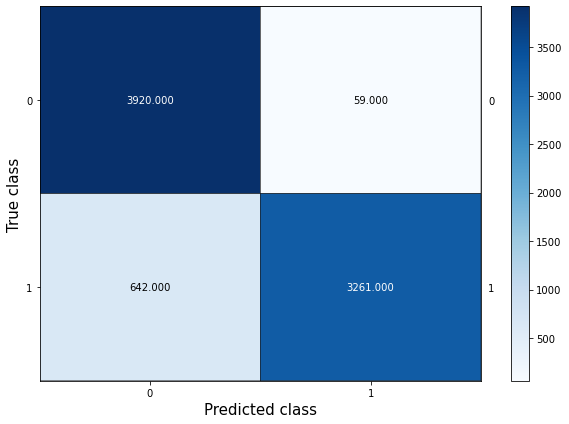

In [332]:
from sklearn.metrics.cluster import contingency_matrix
from plotmat import plot_mat

mat = contingency_matrix(y_full, y_pred)
plot_mat(mat, size=(8,6), xlabel='Predicted class', ylabel='True class')

**Question 2**: The contingency table is displayed above. A contingency matrix does not have to be square-shaped. The table is square-shaped only if the number of clusters matches the number of true classes, such as in this case, but in general a clustering algorithm may find a different number of clusters.

In [333]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure, adjusted_rand_score, adjusted_mutual_info_score

def cluster_metrics(labels_true, labels_pred, print_metrics=False):
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels_true, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    ami = adjusted_mutual_info_score(labels_true, labels_pred)
    metrics_list = [homogeneity, completeness, v_measure, ari, ami]

    if print_metrics:
        print_cluster_metrics(metrics_list)
    else:
        return metrics_list

def print_cluster_metrics(metrics_list):
    print('Homogeneity: {}'.format(metrics_list[0]))
    print('Completeness: {}'.format(metrics_list[1]))
    print('V-Measure: {}'.format(metrics_list[2]))
    print('Adjusted Rand Index: {}'.format(metrics_list[3]))
    print('Adjusted mutual info: {}'.format(metrics_list[4]))

In [334]:
cluster_metrics(y_full, y_pred, print_metrics=True)

Homogeneity: 0.6064971961625802
Completeness: 0.6175638141067112
V-Measure: 0.6119804790200591
Adjusted Rand Index: 0.6758509044067856
Adjusted mutual info: 0.6119446343007903


**Question 3**: The homogeneity, completeness, V-Measure, adjusted Rand Index, and adjusted mutual information score for K-means clustering are reported above.

## Clustering with Dense Text Representations


### Generate dense representations for better K-means clustering

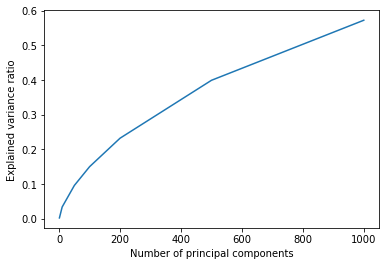

In [335]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

r_list = [1, 10, 50, 100, 200, 500, 1000]
var_list = []

for r in r_list:
    lsi = TruncatedSVD(n_components=r, n_iter=100)
    lsi.fit(X_tfidf)
    var_list.append(lsi.explained_variance_ratio_.sum())

plt.figure()
plt.plot(r_list, var_list)
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance ratio")
plt.show()

**Question 4**: The explained variance plot is above.

In [336]:
# truncated SVD

r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_metrics_list = []

lsi = TruncatedSVD(n_components=1000, n_iter=100)
X_svd = lsi.fit_transform(X_tfidf)

for r in r_list:
    X_svd_r = X_svd[:,:r]
    kmeans = KMeans(n_clusters=2, init='random', n_init=30, max_iter=1000, random_state=0)
    y_pred = kmeans.fit_predict(X_svd_r)
    svd_metrics_list.append(cluster_metrics(y_full, y_pred))

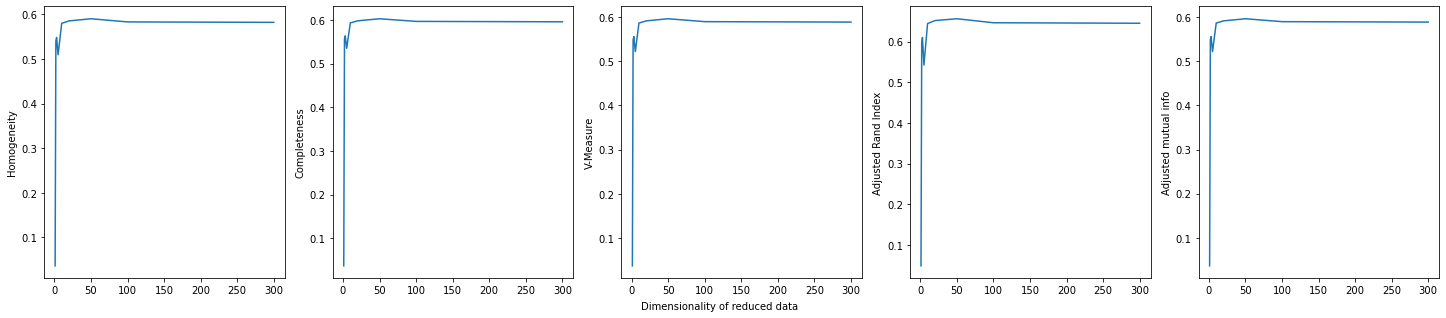

In [337]:
svd_metrics_arr = np.asarray(svd_metrics_list)
fig, axs = plt.subplots(1,5,figsize=(25,5))

metrics_label = ['Homogeneity', 'Completeness', 'V-Measure', 'Adjusted Rand Index', 'Adjusted mutual info']
for i in np.arange(5):
    axs[i].plot(r_list, svd_metrics_arr[:,i])
    axs[i].set_ylabel(metrics_label[i])
fig.text(0.5, 0.04, 'Dimensionality of reduced data', ha='center')
plt.show()

In [361]:
# highest SVD metrics
print_cluster_metrics(svd_metrics_list[3])

Homogeneity: 0.5093691952608577
Completeness: 0.5350194470986603
V-Measure: 0.5218793352671123
Adjusted Rand Index: 0.5421709418748613
Adjusted mutual info: 0.5218344872389079


In [338]:
# NMF
from sklearn.decomposition import NMF

r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
nmf_metrics_list = []

for r in r_list:
    nmf_model = NMF(n_components=r, init='random', max_iter=500, random_state=42)
    X_nmf = nmf_model.fit_transform(X_tfidf)
    kmeans = KMeans(n_clusters=2, init='random', n_init=30, max_iter=1000, random_state=0)
    y_pred = kmeans.fit_predict(X_nmf)
    nmf_metrics_list.append(cluster_metrics(y_full, y_pred))

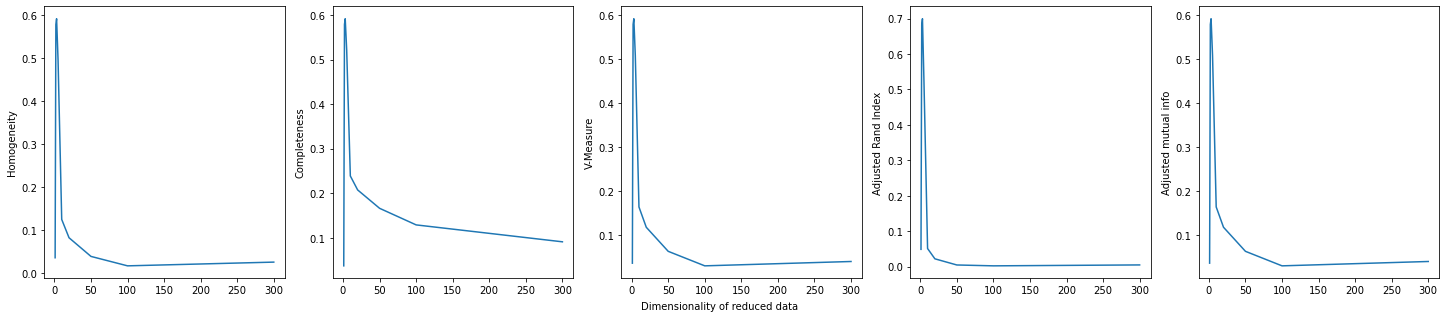

In [339]:
nmf_metrics_arr = np.asarray(nmf_metrics_list)
fig, axs = plt.subplots(1,5,figsize=(25,5))

metrics_label = ['Homogeneity', 'Completeness', 'V-Measure', 'Adjusted Rand Index', 'Adjusted mutual info']
for i in np.arange(5):
    axs[i].plot(r_list, nmf_metrics_arr[:,i])
    axs[i].set_ylabel(metrics_label[i])
fig.text(0.5, 0.04, 'Dimensionality of reduced data', ha='center')
plt.show()

In [362]:
# highest metrics
print_cluster_metrics(nmf_metrics_list[1])

Homogeneity: 0.5782237421214756
Completeness: 0.5789623090479784
V-Measure: 0.5785927898918131
Adjusted Rand Index: 0.6821241912434625
Adjusted mutual info: 0.5785541853005189


**Question 5**: The plots of evluation metrics v.s. $r$ for both SVD and NMF are shown above. A good choice of $r$ for SVM is 50, since it achieves the highest scores across all five metrics. Similarly, a good choice of $r$ for NMF is 2 since it achieves the highest scores.

**Question 6**: The curves are non-monotonic because although higher $r$ values preserve more information about the data, K-means clustering does not perform well with higher dimensional data due to the curse of dimensionality.

**Question 7**: These measures are on average worse than those computed in Q3. In Q3, all measures were greater than 0.6, but the scores for SVD and NMF are generally below 0.6.

### Visualize the clusters

In [340]:
# create dense representations with optimal r
svd_r = 50
lsi = TruncatedSVD(n_components=svd_r, n_iter=100)
X_svd = lsi.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=2, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred_svd = kmeans.fit_predict(X_svd)

nmf_r = 2
nmf_model = NMF(n_components=nmf_r, init='random', max_iter=500, random_state=42)
X_nmf = nmf_model.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=2, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred_nmf = kmeans.fit_predict(X_nmf)

# project to 2D
lsi = TruncatedSVD(n_components=2, n_iter=100)
X_svd_vis = lsi.fit_transform(X_svd)
# X_nmf_vis = lsi.fit_transform(X_nmf)
X_nmf_vis = X_nmf # if nmf_r=2

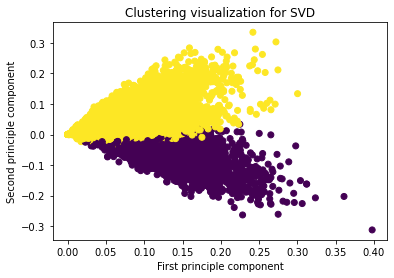

In [341]:
# SVD visualization
plt.scatter(X_svd_vis[:,0], X_svd_vis[:,1], c=y_pred_svd)
plt.title('Clustering visualization for SVD')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.show()

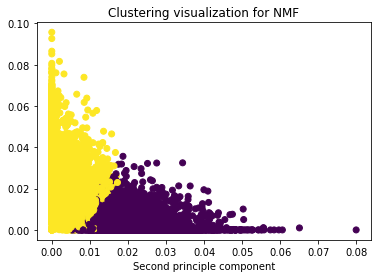

In [342]:
# NMF visualization
plt.scatter(X_nmf_vis[:,0], X_nmf_vis[:,1], c=y_pred_svd)
plt.title('Clustering visualization for NMF')
plt.xlabel('First principle component')
plt.xlabel('Second principle component')
plt.show()

**Question 9**: In 2D, the two classes do not appear to be to grouped together in separate isotropically shaped clusters. This means that K-means may perform poorly, since it assumes classes are related by their L2 norm. However, the 2D visualization suggests that the classes fall on either side of a boundary, and each class does not have a spherical distribution, so the data is not ideal for K-means clustering.

### Clustering of the entire 20 classes

In [343]:
X, y = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, remove=("headers", "footers"), return_X_y=True)
print(len(X))
print(y.shape)

18846
(18846,)


In [344]:
# construct TF-IDF matrix

X_clean = [clean(doc) for doc in X]

vectorizer = CountVectorizer(stop_words=combined_stopwords, min_df=3, max_df=0.7)
X_counts = vectorizer.fit_transform(X_clean)

tfidf_transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(18846, 37749)


In [345]:
# reduce dimensionality with SVD

svd_r = 50
lsi = TruncatedSVD(n_components=svd_r, n_iter=100)
X_svd = lsi.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=20, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred = kmeans.fit_predict(X_svd)

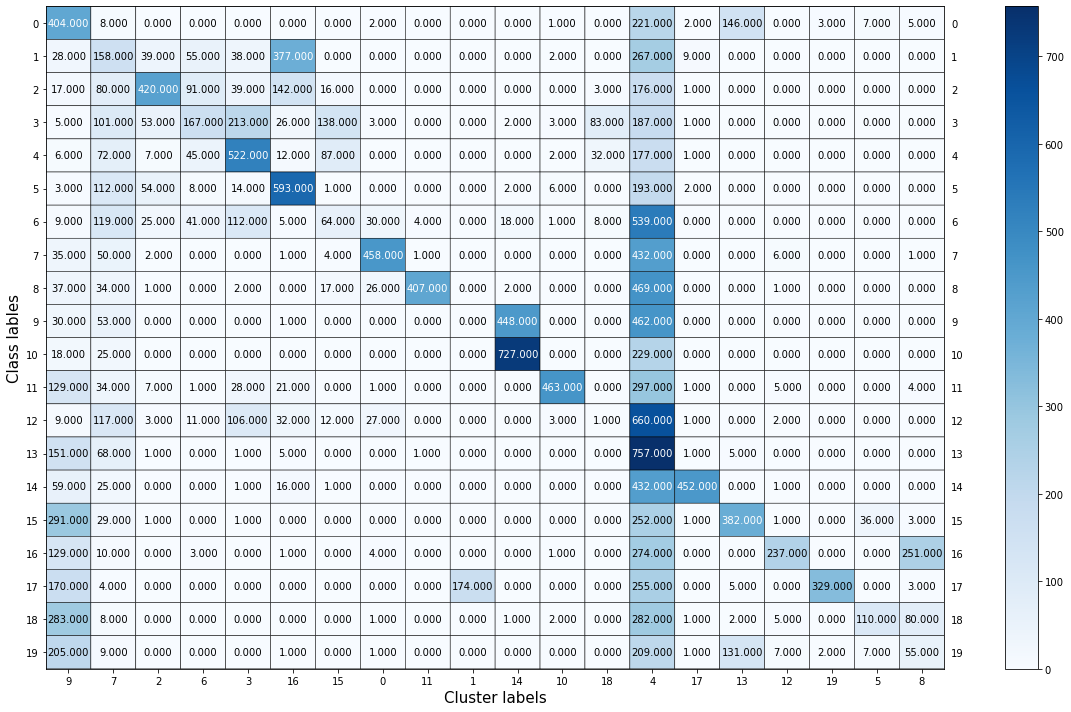

In [347]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:,np.newaxis], cols], xticklabels=cols, yticklabels=rows, xlabel="Cluster labels", ylabel="Class lables", size=(15,10))

In [352]:
cluster_metrics(y, y_pred, print_metrics=True)

Homogeneity: 0.5551832460672587
Completeness: 0.5943476165966497
V-Measure: 0.5740982687664321
Adjusted Rand Index: 0.42617290848912814
Adjusted mutual info: 0.5726618438174442


**Question 10**: The contingency matrix and clustering metrics are above.

### UMAP

In [349]:
import umap

n_components_list = [5, 20, 200]
metrics_list = ['euclidean', 'cosine']
eval_metrics_list = []

for metric in metrics_list:
    for n_components in n_components_list:
        reducer = umap.UMAP(n_components=n_components, metric=metric)
        embedding = reducer.fit_transform(X_tfidf)
        
        kmeans = KMeans(n_clusters=20, init='random', n_init=30, max_iter=1000, random_state=0)
        y_pred = kmeans.fit_predict(embedding)
        eval_metrics_list.append(cluster_metrics(y, y_pred))

In [353]:
# evaluation metrics for "euclidean" metric

euc_metrics = np.asarray(eval_metrics_list)[:len(eval_metrics_list)//2]
print(euc_metrics)

[[0.0123693  0.01272072 0.01254255 0.00241198 0.00928209]
 [0.01508113 0.01598591 0.01552034 0.00281718 0.01222763]
 [0.01295839 0.01399827 0.01345827 0.00293747 0.0101525 ]]


In [354]:
# optimal n_components for "euclidean" metric

best_idx = 1 # row with highest scores
best_n_components = n_components_list[best_idx]

print("Best n_components: {}".format(best_n_components))
print_cluster_metrics(euc_metrics[best_idx,:])

Best n_components: 20
Homogeneity: 0.015081125127851631
Completeness: 0.015985906533564274
V-Measure: 0.015520340619747261
Adjusted Rand Index: 0.002817176697411078
Adjusted mutual info: 0.012227631048587704


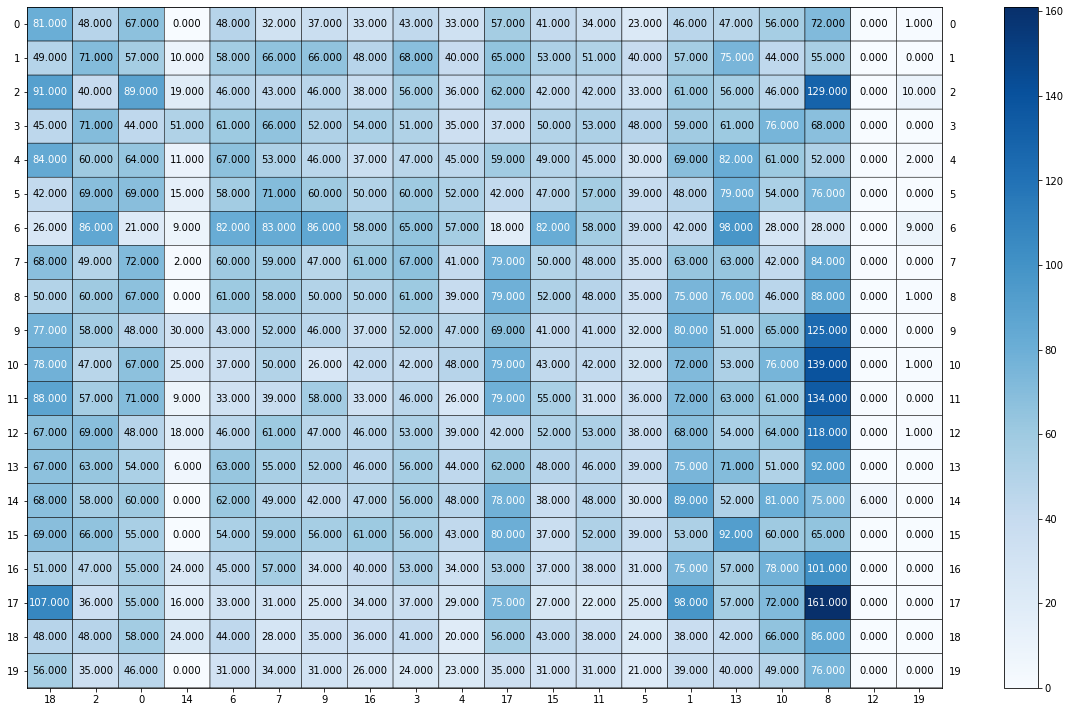

In [355]:
# contingency matrix for "euclidean" metric

reducer = umap.UMAP(n_components=best_n_components, metric='euclidean')
X_euc = reducer.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=20, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred = kmeans.fit_predict(X_euc)

cm = confusion_matrix(y, y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:,np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,10))

In [356]:
# evaluation metrics for "cosine" metric

cos_metrics = np.asarray(eval_metrics_list)[len(eval_metrics_list)//2:]
print(cos_metrics)

[[0.54778524 0.58524671 0.56589668 0.41219631 0.56443417]
 [0.55114379 0.57130628 0.56104395 0.42557642 0.55958927]
 [0.55518325 0.59434762 0.57409827 0.42617291 0.57266184]]


In [357]:
# optimal n_components for "cosine" metric

best_idx = 2 # row with highest scores
best_n_components = n_components_list[best_idx]

print("Best n_components: {}".format(best_n_components))
print_cluster_metrics(cos_metrics[best_idx,:])

Best n_components: 200
Homogeneity: 0.5551832460672587
Completeness: 0.5943476165966497
V-Measure: 0.5740982687664321
Adjusted Rand Index: 0.42617290848912814
Adjusted mutual info: 0.5726618438174442


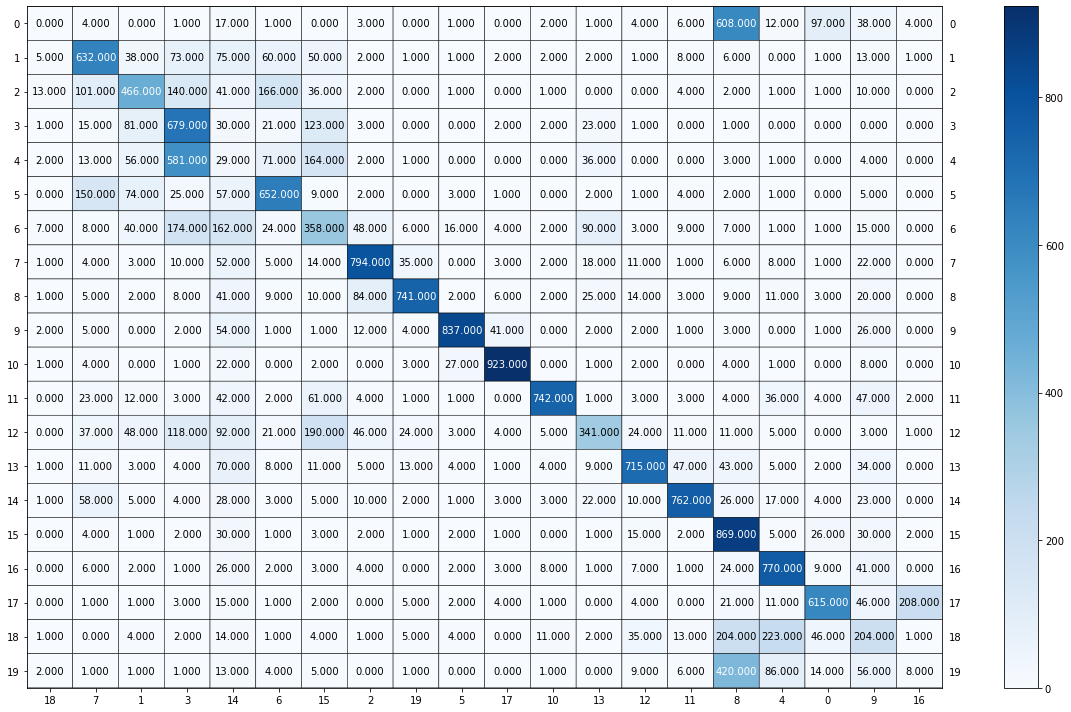

In [358]:
# contingency matrix for "cosine" metric

reducer = umap.UMAP(n_components=best_n_components, metric='cosine')
X_cos = reducer.fit_transform(X_tfidf)
kmeans = KMeans(n_clusters=20, init='random', n_init=30, max_iter=1000, random_state=0)
y_pred = kmeans.fit_predict(X_cos)

cm = confusion_matrix(y, y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:,np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,10))

**Question 11**: A good n_components choice for "euclidean" metrics is 20, which achieved the highest homogeneity, completeness, V-measure, and adjusted mutual info. A good n_components choice for "cosine" metric is 500 since it achieved the highest scores for all five clustering evaluation metrics. The contingency matrix and clustering metrics for "euclidean" and "cosine" distance metrics are above.

**Question 12**: The contingency matrix for "euclidean" shows poor performance, because there are many high values off the main diagonal and some low values on the main diagonal, so K-means clustering is clustering many data points incorrectly. In contrast, the contingency matrix for "cosine" shows a clear main diagonal with many high values and mostly low values everywhere else, so K-means clustering is generally clustering the data correctly, and making mistakes with only some classes, such as predicting class 8 for class 0.

**Question 13**:

## Clustering Algorithms that do not rely on Gaussian Distribution

In [363]:
# reduce dimensionality with UMAP

reducer = umap.UMAP(n_components=200, metric='cosine')
embedding = reducer.fit_transform(X_tfidf)

### Agglomerative clustering

In [364]:
from sklearn.cluster import AgglomerativeClustering

# 'ward' linkage
print("'ward' linkage")
clustering = AgglomerativeClustering(n_clusters=20, linkage='ward')
y_pred = clustering.fit_predict(embedding)
cluster_metrics(y, y_pred, print_metrics=True)

# 'single' linkage
print("\n'single' linkage")
clustering = AgglomerativeClustering(n_clusters=20, linkage='single')
y_pred = clustering.fit_predict(embedding)
cluster_metrics(y, y_pred, print_metrics=True)

'ward' linkage
Homogeneity: 0.5388510402611808
Completeness: 0.5897496105725395
V-Measure: 0.5631525923999482
Adjusted Rand Index: 0.39248082101444015
Adjusted mutual info: 0.56167108634169

'single' linkage
Homogeneity: 0.006728507631571251
Completeness: 0.24722829390757953
V-Measure: 0.013100475767655642
Adjusted Rand Index: -3.8525914549030366e-05
Adjusted mutual info: 0.007969140043697087


**Question 14**: The clustering evaluation metrics for agglomerative clustering are above.

## DBSCAN and HDBSCAN

In [365]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5)
y_pred = clustering.fit_predict(embedding)
cluster_metrics(y, y_pred, print_metrics=True)

Homogeneity: 0.10664332055848488
Completeness: 0.6066197996373831
V-Measure: 0.1813971532191048
Adjusted Rand Index: 0.02079672188184964
Adjusted mutual info: 0.17508870769716642


In [366]:
import hdbscan

min_cluster_size_list = [100, 200]

for min_cluster_size in min_cluster_size_list:
    print("min_cluster_size: {}".format(min_cluster_size))
    clustering = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    y_pred = clustering.fit_predict(embedding)
    cluster_metrics(y, y_pred, print_metrics=True)

min_cluster_size: 100
Homogeneity: 0.4014309304392313
Completeness: 0.5865698989371588
V-Measure: 0.4766540539173689
Adjusted Rand Index: 0.1740696500100282
Adjusted mutual info: 0.4752759395436289
min_cluster_size: 200
Homogeneity: 0.3957547408386688
Completeness: 0.59453010371125
V-Measure: 0.4751927860149578
Adjusted Rand Index: 0.18374253085956102
Adjusted mutual info: 0.4741224176126034


**Question 15**: The clustering evaluation metrics for DBSCAN with eps=0.5 and HDBSCAN with min_cluster_size = [100,200] are reported above. HDBSCAN with min_cluster_size=100 performs better than HDBSCAN with min_cluster_size=200 in all evaluation metrics except Adjusted Rand Index, and both HDBSCAN methods perform better than DBSCAN except in completeness.

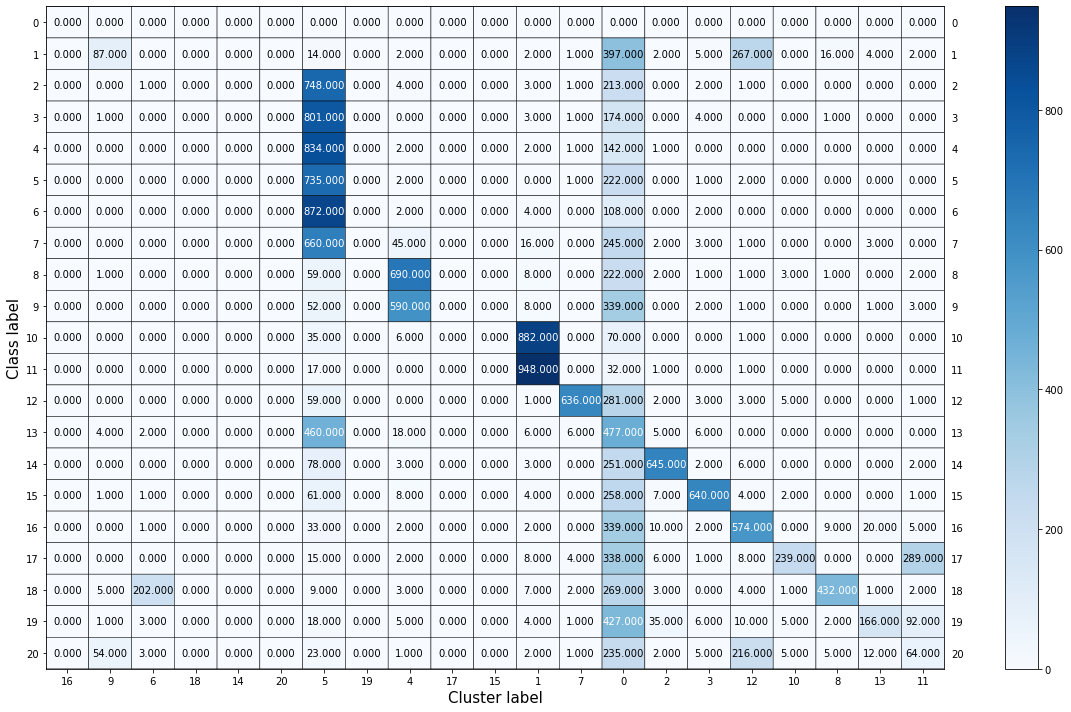

In [369]:
clustering = hdbscan.HDBSCAN(min_cluster_size=100)
y_pred = clustering.fit_predict(embedding)

cm = confusion_matrix(y, y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:,np.newaxis], cols], xticklabels=cols, yticklabels=rows, xlabel="Cluster label", ylabel="Class label", size=(15,10))

In [371]:
# noise cluster
clustering.labels_.min()

-1

In [370]:
# number of clusters
clustering.labels_.max()

12

**Question 16**: The best clustering model from Q15 is HDBSCAN with min_cluster_size=100, and the contingency matrix is shown above. The model found 13 clusters. A "-1" label means that the data point was labeled as noise and not assigned to any cluster. The contingency matrix shows that classes 2 through 7 were clustered together along with many data points in class 13. Similarly, classes 8 and 9 were clustered together, and classes 10 and 11 were clustered together. Some predicted classes have all zeros since the model did not predict as many clusters as there are classes.

In [86]:
svd_r = [5,20,200]
nmf_r = [5,20,200]
umap_n_components = [5,20,200]

k_means_k = [10,20,50]
agg_n_clusters = [20]
db_eps = [0.5,5]
hdb_size = [100,200]

eval_metrics = []

for i in range(1):
    # dimensionality reduction
    if i<8: # none
        print("Dimensionality reduction: none")
        X_red = X_tfidf
    elif i<32: # svd
        print("Dimensionality reduction: SVD, r={}".format(svd_r[(i//8)-1]))
        X_red = TruncatedSVD(n_components=svd_r[(i//8)-1], n_iter=100).fit_transform(X_tfidf)
    elif i<56: # nmf
        print("Dimensionality reduction: NMF, r={}".format(nmf_r[(i//8)-4]))
        X_red = NMF(n_components=nmf_r[(i//8)-4], init='random', max_iter=500, random_state=42).fit_transform(X_tfidf)
    else: # umap
        print("Dimensionality reduction: UMAP, n_components={}".format(umap_n_components[(i//8)-7]))
        X_red = umap.UMAP(n_components=umap_n_components[(i//8)-7], metric='cosine').fit_transform(X_tfidf)
    # clustering
    if (i%8)<3: # k_means
        print("Clustering: K-means, k={}".format(k_means_k[i%8]))
        clustering = KMeans(n_clusters=k_means_k[i%8], init='random', n_init=30, max_iter=1000, random_state=0)
    elif (i%8)<4: # agglomerative clustering
        print("Clustering: Agglomerative clustering, n_clusters=0")
        clustering = AgglomerativeClustering(n_clusters=agg_n_clusters[0], linkage='ward')
    elif (i%8)<6: # DBSCAN
        print("Clustering: DBSCAN, eps={}".format(db_eps[(i%8)-4]))
        clustering = DBSCAN(eps=db_eps[(i%8)-4])
    else:
        print("Clustering: HDBSCAN, min_cluster_size={}".format(hdb_size[(i%8)-6]))
        clustering = hdbscan.HDBSCAN(min_cluster_size=hdb_size[(i%8)-6])

    y_pred = clustering.fit_predict(X_red)
    eval_metrics.append(cluster_metrics(y, y_pred))

Dimensionality reduction: none
Clustering: K-means, k=10


**Question 17**:

**Question 18**:

#  Deep Learning and Clustering of Image Data

**Question 19**:

**Question 20**:

**Question 21**:

**Question 22**:

**Question 23**:

**Question 24**:

**Question 25**: